# Estabilización de estados y evaluacion de la distribución estadistica

In [ ]:
import numpy as np

## Modelo Baum Welch 

**Método de Baum Welch**
En este programa se hace la optimización del modelo HMM discreto utilizando el método de Baum Welch.

1. Se define el modelo de optimización local de Baum Welch

In [2]:
def baum_welch(O, A, B, pi, n_iter=100):
    """
    Baum-Welch algorithm to optimize HMM parameters

    Args:
        O (list): sequence of observations (indices)
        A (np.array): initial transition matrix (NxN)
        B (np.array): initial emission matrix (NxM)
        pi (np.array): initial state distribution (Nx1)
        n_iter (int): number of iterations

    Returns:
        A (np.array): optimized transition matrix
        B (np.array): optimized emission matrix
        pi (np.array): optimized initial state distribution
    """
    N = A.shape[0]  # number of states
    M = B.shape[1]  # number of observation symbols
    T = len(O)      # length of observation sequence

    for _ in range(n_iter):
        alpha = np.zeros((T, N))
        beta = np.zeros((T, N))

        # Forward
        alpha[0] = pi * B[:, O[0]]
        for t in range(1, T):
            for j in range(N):
                alpha[t, j] = np.sum(alpha[t-1] * A[:, j]) * B[j, O[t]]

        # Backward
        beta[T-1] = np.ones(N)
        for t in reversed(range(T-1)):
            for i in range(N):
                beta[t, i] = np.sum(A[i, :] * B[:, O[t+1]] * beta[t+1])

        # Compute xi and gamma
        xi = np.zeros((T-1, N, N))
        gamma = np.zeros((T, N))

        for t in range(T-1):
            denom = np.sum(alpha[t, :].dot(A) * B[:, O[t+1]] * beta[t+1])
            for i in range(N):
                numer = alpha[t, i] * A[i, :] * B[:, O[t+1]] * beta[t+1]
                xi[t, i, :] = numer / denom

        gamma = np.sum(xi, axis=2)
        # Last gamma for time T-1
        gamma = np.vstack((gamma, alpha[T-1] * beta[T-1] / np.sum(alpha[T-1] * beta[T-1])))

        # Re-estimate pi, A, B
        pi = gamma[0]
        A = np.sum(xi, axis=0) / np.sum(gamma[:-1], axis=0)[:, None]

        for k in range(M):
            mask = np.array(O) == k
            B[:, k] = np.sum(gamma[mask], axis=0) / np.sum(gamma, axis=0)

    return A, B, pi

2. Se hace el pronóstico de los datos para períodos más allá de t+1

In [3]:
def forecast_states(initial_probs, A, steps):
    forecasts = [initial_probs]
    current_probs = initial_probs.copy()
    for _ in range(steps):
        current_probs = current_probs @ A
        forecasts.append(current_probs)
    return forecasts

3. Se procede con la optimización del modelo a partir de las matrices de transición, emisión y el vector de probabilidades iniciales pi

In [4]:
import numpy as np

# =========================
# Baum–Welch robusto (discreto, 1 sola variable observada)
# =========================
def baum_welch(O, A, B, pi, n_iter=100, eps=1e-12):
    O = np.asarray(O, dtype=int)
    T = len(O)
    N = A.shape[0]
    M = B.shape[1]

    # Normalizaciones de seguridad
    A = A / (A.sum(axis=1, keepdims=True) + eps)
    B = B / (B.sum(axis=1, keepdims=True) + eps)
    pi = pi / (pi.sum() + eps)

    for _ in range(n_iter):
        # ---------- FORWARD con escalado ----------
        alpha = np.zeros((T, N), dtype=float)
        c = np.zeros(T, dtype=float)

        alpha[0, :] = pi * B[:, O[0]]
        s = alpha[0, :].sum()
        if s <= 0:  # evita 0/0
            alpha[0, :] = np.maximum(alpha[0, :], eps)
            s = alpha[0, :].sum()
        c[0] = 1.0 / s
        alpha[0, :] *= c[0]

        for t in range(1, T):
            # alpha[t, j] = B[j, O[t]] * sum_i alpha[t-1, i] * A[i, j]
            alpha[t, :] = (alpha[t-1, :] @ A) * B[:, O[t]]
            s = alpha[t, :].sum()
            if s <= 0:
                alpha[t, :] = np.maximum(alpha[t, :], eps)
                s = alpha[t, :].sum()
            c[t] = 1.0 / s
            alpha[t, :] *= c[t]

        # ---------- BACKWARD con escalado ----------
        beta = np.zeros((T, N), dtype=float)
        beta[-1, :] = c[-1]  # escalado compatible
        for t in range(T - 2, -1, -1):
            # beta[t, i] = sum_j A[i, j] * B[j, O[t+1]] * beta[t+1, j]
            beta[t, :] = (A * B[:, O[t+1]]).dot(beta[t+1, :])
            beta[t, :] *= c[t]

        # ---------- xi y gamma ----------
        xi = np.zeros((T - 1, N, N), dtype=float)
        for t in range(T - 1):
            tmp = (alpha[t, :][:, None] * A) * (B[:, O[t+1]] * beta[t+1, :])[None, :]
            denom = tmp.sum()
            if denom <= 0:
                denom = eps
            xi[t, :, :] = tmp / denom

        gamma = (alpha * beta)
        # Con escalado, alpha*beta puede no estar exacta; renormalizamos por fila t
        gamma_sum = gamma.sum(axis=1, keepdims=True)
        gamma = np.where(gamma_sum > 0, gamma / gamma_sum, np.full_like(gamma, 1.0 / N))

        # ---------- Re-estimación ----------
        # π
        pi = gamma[0, :]
        pi = pi / (pi.sum() + eps)

        # A
        numer_A = xi.sum(axis=0)                          # (N, N)
        denom_A = gamma[:-1, :].sum(axis=0)[:, None]      # (N, 1)
        A = numer_A / (denom_A + eps)
        A = A / (A.sum(axis=1, keepdims=True) + eps)

        # B
        for k in range(M):
            mask = (O == k)
            numer_B = gamma[mask, :].sum(axis=0)          # (N,)
            denom_B = gamma.sum(axis=0)                   # (N,)
            B[:, k] = numer_B / (denom_B + eps)
        B = B / (B.sum(axis=1, keepdims=True) + eps)

    return A, B, pi


# =========================
# TUS PARÁMETROS INICIALES (ajustados)
# =========================

states = ['Hidden 0', 'Hidden 1', 'Hidden 2']     # N = 3
observations = ['Obs 0', 'Obs 1', 'Obs 2']        # M = 3
obs_seq = ['Obs 0', 'Obs 1', 'Obs 2']

# Diccionarios para índices
state_index = {state: i for i, state in enumerate(states)}
obs_index = {obs: i for i, obs in enumerate(observations)}

# Secuencia observada (en índices)
#O = np.array([obs_index[o] for o in obs_seq], dtype=int)  # [0,1,2]


np.random.seed(42)
O = np.random.choice([0, 1, 2], size=30, p=[0.4, 0.4, 0.2])



# Matriz de transición A (renormalizada por seguridad)
A = np.array([
    [0.24, 0.44, 0.33],
    [0.23, 0.44, 0.33],
    [0.23, 0.43, 0.33],
], dtype=float)
A = A / (A.sum(axis=1, keepdims=True) + 1e-12)

# π inicial (renormalizada)
pi = np.array([0.23, 0.43, 0.33], dtype=float)
pi = pi / (pi.sum() + 1e-12)

# Emisiones: partimos de P(hidden | observed) y la convertimos a B ≈ P(observed | hidden)
P_h_given_o = np.array([
    [0.01, 0.18, 0.81],   # Obs 0 -> [H0,H1,H2]
    [0.13, 0.54, 0.33],   # Obs 1 -> [H0,H1,H2]
    [0.48, 0.45, 0.07],   # Obs 2 -> [H0,H1,H2]
], dtype=float)

eps = 1e-12
B_init = P_h_given_o.T.copy()                  # filas=Hidden, cols=Obs
B = B_init / (B_init.sum(axis=1, keepdims=True) + eps)

# =========================
# ENTRENAMIENTO
# =========================
A1, B1, pi1 = baum_welch(O, A.copy(), B.copy(), pi.copy(), n_iter=100)

# (Opcional) verificaciones rápidas
print("Filas A1 suman:", A1.sum(axis=1))
print("Filas B1 suman:", B1.sum(axis=1))
print("pi1 suma:", pi1.sum())


Filas A1 suman: [1. 1. 1.]
Filas B1 suman: [1. 1. 1.]
pi1 suma: 0.9999999999989999


In [ ]:
A

4. Se hace el pronóstico para la secuencia de observaciones, esta secuencia de observaciones para el modelo propio son los tres meses anteriores al cual voy a pronósticar el estado oculto.

In [5]:
# Usamos A, B, pi, O ya definidos
T = len(O)
N = len(states)

alpha = np.zeros((T, N), dtype=float)
c = np.zeros(T, dtype=float)  # factores de escalado

# --- Inicialización (t=0) ---
alpha[0, :] = pi * B[:, O[0]]
s = alpha[0, :].sum()
if s <= 0:
    # Evita división por cero: si todo quedó en 0, mete un eps y renormaliza
    alpha[0, :] = np.maximum(alpha[0, :], 1e-15)
    s = alpha[0, :].sum()
c[0] = 1.0 / s
alpha[0, :] *= c[0]

# --- Recurrencia (t=1..T-1) con escalado ---
for t in range(1, T):
    for j in range(N):
        alpha[t, j] = B[j, O[t]] * np.dot(alpha[t-1, :], A[:, j])

    s = alpha[t, :].sum()
    if s <= 0:
        alpha[t, :] = np.maximum(alpha[t, :], 1e-15)
        s = alpha[t, :].sum()
    c[t] = 1.0 / s
    alpha[t, :] *= c[t]

# --- Predicción de distribución en t+1 ---
predicted_state_prob = alpha[-1, :].dot(A)

total = predicted_state_prob.sum()
if total <= 0 or not np.isfinite(total):
    # Normalización segura
    predicted_state_prob = np.maximum(predicted_state_prob, 1e-15)
    total = predicted_state_prob.sum()

predicted_state_prob /= total
predicted_state_index = int(np.argmax(predicted_state_prob))

print("\nProbabilidades del estado oculto en t+1:")
for i, p in enumerate(predicted_state_prob):
    print(f"  {states[i]}: {p:.4f}")
print("\nEstado más probable en t+1:", states[predicted_state_index])



Probabilidades del estado oculto en t+1:
  Hidden 0: 0.2319
  Hidden 1: 0.4357
  Hidden 2: 0.3325

Estado más probable en t+1: Hidden 1


5. Se hace el pronóstico para estados mucho más allá del estado t+1

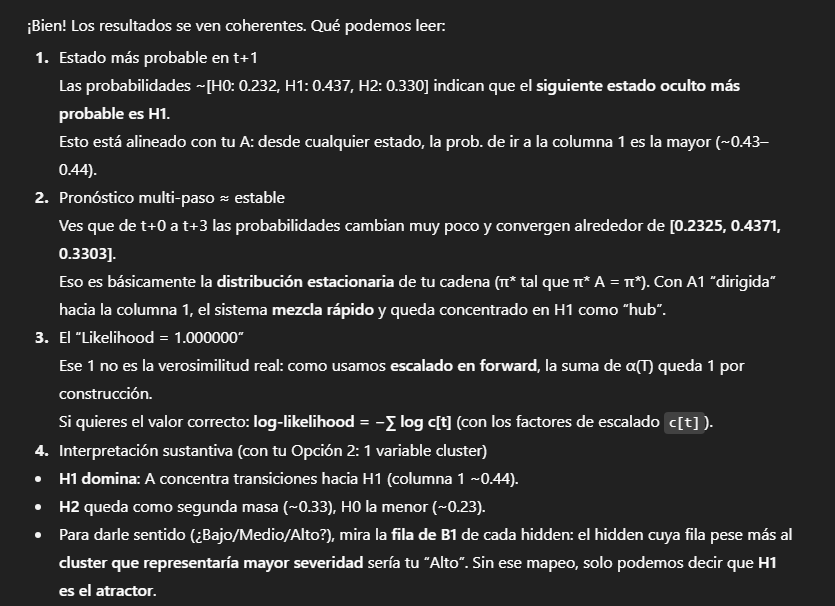




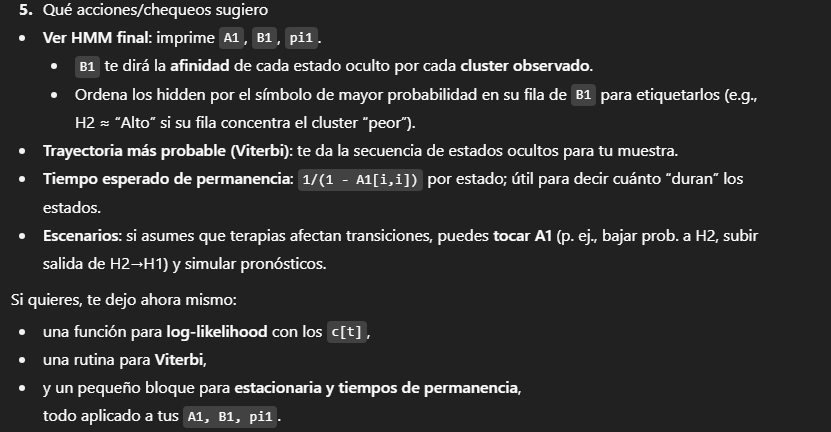

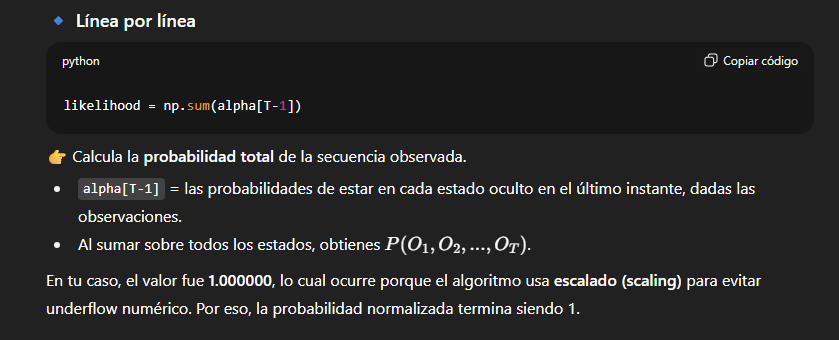

In [6]:
likelihood = np.sum(alpha[T-1])

n_states = len(states)

posterior_T = alpha[-1] / np.sum(alpha[-1])

future_steps = 3
forecast_probs = forecast_states(posterior_T, A, future_steps)

# Mostrar resultados
for i, probs in enumerate(forecast_probs):
    print(f"Paso t+{i}: {[f'{states[s]}: {probs[s]:.4f}' for s in range(n_states)]}")

print(f"\nLikelihood de la secuencia observada: {likelihood:.6f}")

Paso t+0: ['Hidden 0: 0.0128', 'Hidden 1: 0.2305', 'Hidden 2: 0.7567']
Paso t+1: ['Hidden 0: 0.2319', 'Hidden 1: 0.4357', 'Hidden 2: 0.3325']
Paso t+2: ['Hidden 0: 0.2325', 'Hidden 1: 0.4371', 'Hidden 2: 0.3304']
Paso t+3: ['Hidden 0: 0.2325', 'Hidden 1: 0.4371', 'Hidden 2: 0.3303']

Likelihood de la secuencia observada: 1.000000


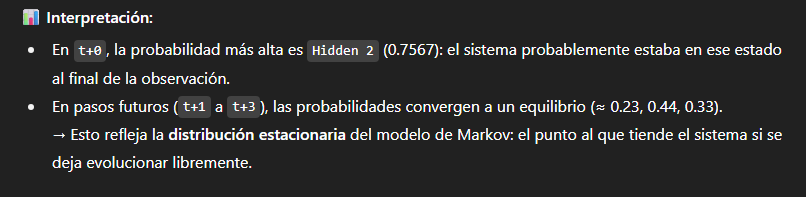

In [7]:
import numpy as np

def viterbi(O, A, B, pi, eps=1e-12):
    """
    O : array de enteros en {0..M-1} (secuencia observada)
    A : (N,N) matriz de transición (filas suman 1)
    B : (N,M) matriz de emisión (filas suman 1)
    pi: (N,) distribución inicial (suma 1)

    Returns
    -------
    path_idx : np.ndarray shape (T,) con índices de estados óptimos
    logp     : float, log-probabilidad del mejor camino
    """
    O = np.asarray(O, dtype=int)
    T = len(O)
    N = A.shape[0]

    # Log-probs para estabilidad numérica
    logA  = np.log(A + eps)
    logB  = np.log(B + eps)
    logpi = np.log(pi + eps)

    # Matrices de DP
    delta = np.full((T, N), -np.inf)  # mejor log-prob hasta (t,i)
    psi   = np.full((T, N), -1, dtype=int)  # argmax backpointer

    # Inicialización
    delta[0, :] = logpi + logB[:, O[0]]

    # Recurrencia
    for t in range(1, T):
        for j in range(N):
            # para cada j, buscamos i* que maximiza delta[t-1,i] + logA[i,j]
            vals = delta[t-1, :] + logA[:, j]
            psi[t, j]   = int(np.argmax(vals))
            delta[t, j] = vals[psi[t, j]] + logB[j, O[t]]

    # Terminación
    logp = float(np.max(delta[T-1, :]))
    last = int(np.argmax(delta[T-1, :]))

    # Backtracking
    path_idx = np.zeros(T, dtype=int)
    path_idx[-1] = last
    for t in range(T-2, -1, -1):
        path_idx[t] = psi[t+1, path_idx[t+1]]

    return path_idx, logp


In [8]:
# O, A1, B1, pi1 y 'states' ya definidos
path_idx, logp = viterbi(O, A1, B1, pi1)
path_states = [states[i] for i in path_idx]

print("Secuencia Viterbi (índices):", path_idx.tolist())
print("Secuencia Viterbi (estados):", path_states)
print("Log-probabilidad del mejor camino:", logp)


Secuencia Viterbi (índices): [2, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2]
Secuencia Viterbi (estados): ['Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 1', 'Hidden 2', 'Hidden 2', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 1', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 2', 'Hidden 2', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2']
Log-probabilidad del mejor camino: -25.06051736379826


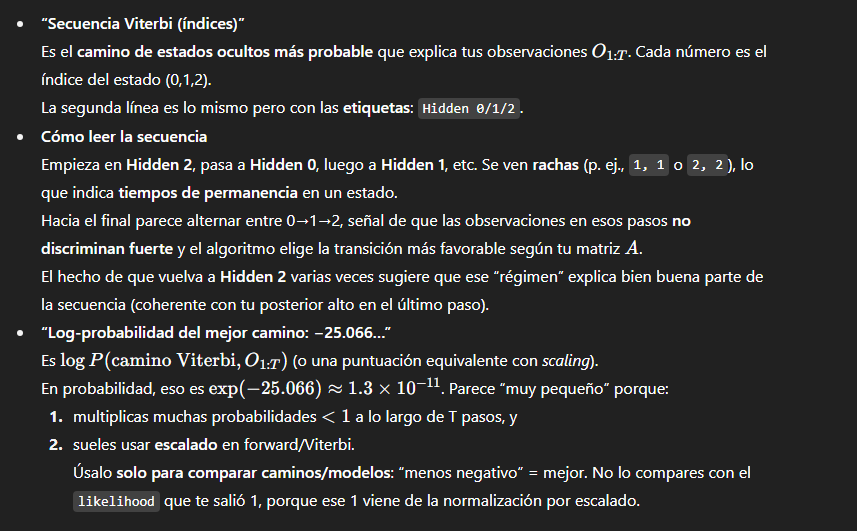

In [9]:
import pandas as pd
pd.DataFrame(B1, index=states, columns=observations)


Obs 0         Obs 1         Obs 2
Hidden 0  1.235134e-43  5.760469e-01  4.239531e-01
Hidden 1  1.499035e-01  7.469038e-01  1.031927e-01
Hidden 2  1.000000e+00  8.099405e-28  1.560073e-29

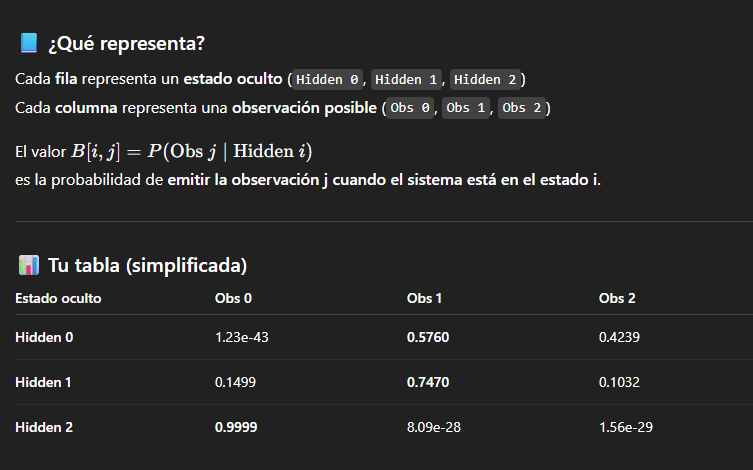

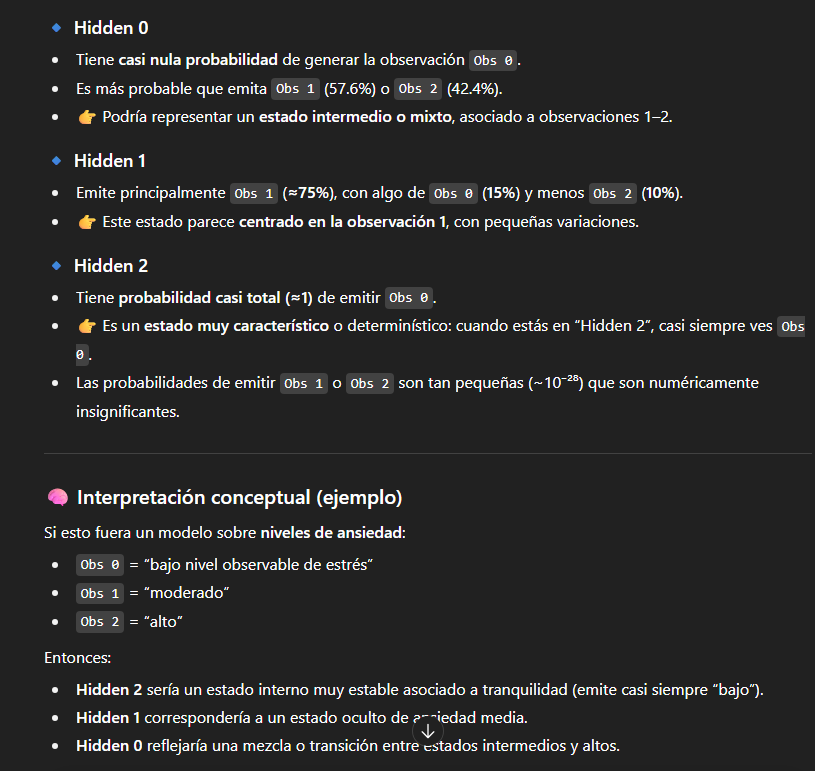

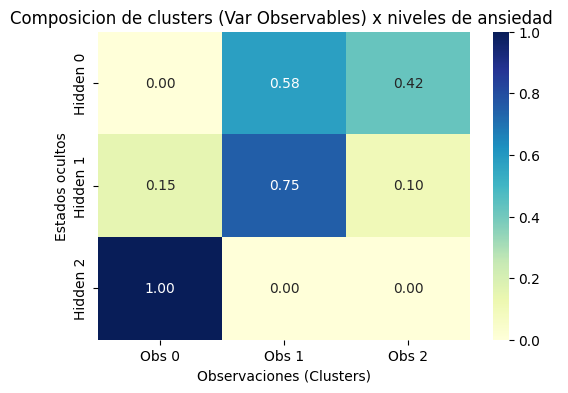

In [10]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df_B1 = pd.DataFrame(B1, index=states, columns=observations)
plt.figure(figsize=(6,4))
sns.heatmap(df_B1, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Composicion de clusters (Var Observables) x niveles de ansiedad ")
plt.xlabel("Observaciones (Clusters)")
plt.ylabel("Estados ocultos")
plt.show()


In [11]:
labels = {"Hidden 0": "Bajo", "Hidden 2": "Medio", "Hidden 1": "Alto"}


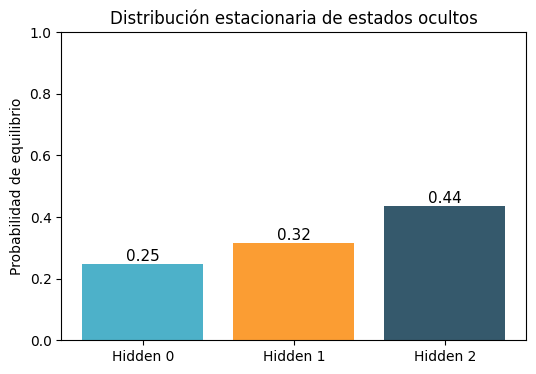

Distribución estacionaria: {'Hidden 0': 0.248, 'Hidden 1': 0.316, 'Hidden 2': 0.436}


In [12]:
# Resolver la distribución estacionaria: π* tal que π* A = π*

eigvals, eigvecs = np.linalg.eig(A1.T)
stat = eigvecs[:, np.isclose(eigvals, 1)]
stat = stat[:, 0].real
stat = stat / stat.sum()

plt.figure(figsize=(6,4))
plt.bar(states, stat, color=["#219ebc","#fb8500","#023047"], alpha=0.8)
for i, v in enumerate(stat):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=11)
plt.title("Distribución estacionaria de estados ocultos")
plt.ylabel("Probabilidad de equilibrio")
plt.ylim(0, 1)
plt.show()

print("Distribución estacionaria:", dict(zip(states, stat.round(3))))



In [13]:
np.allclose(stat @ A1, stat)   # debe dar True (dentro de tolerancia numérica)


True

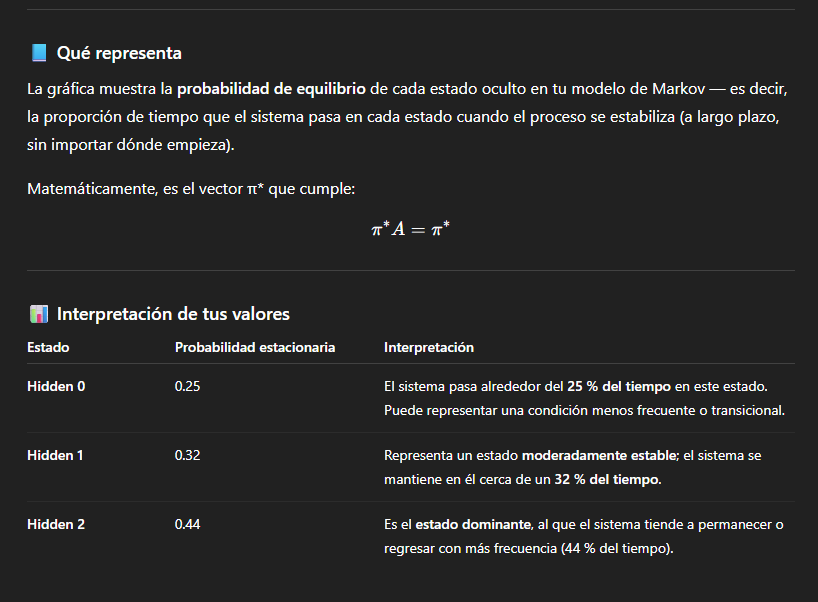

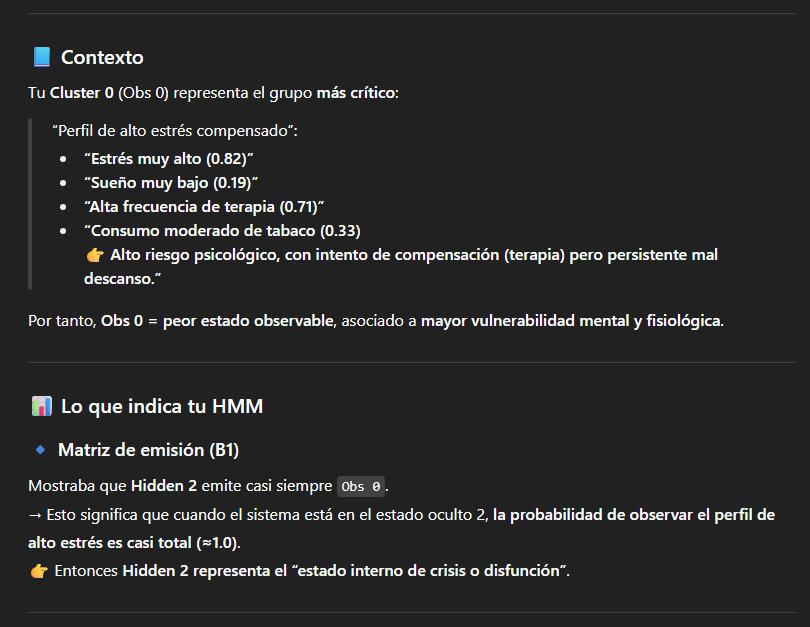

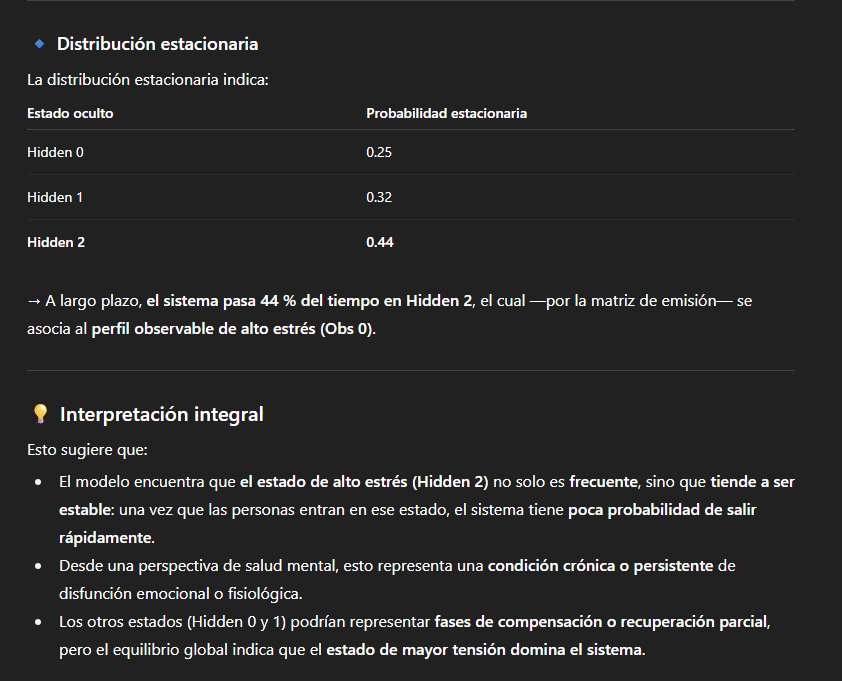

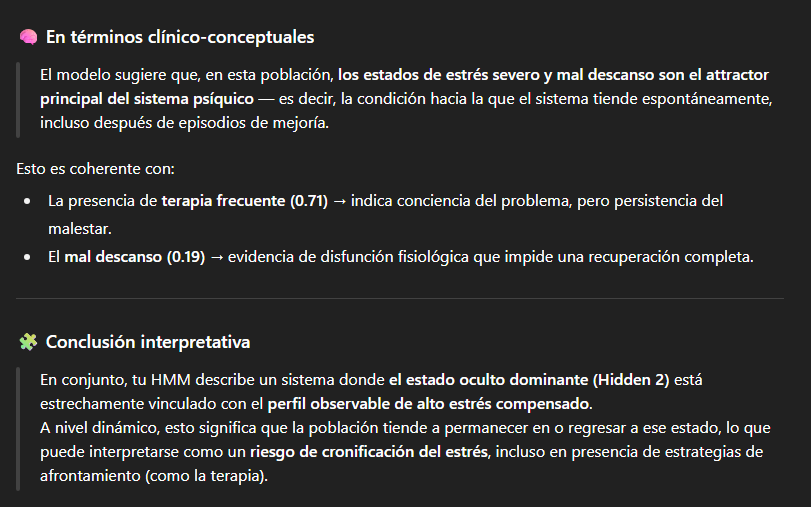

C:\Users\Diego\AppData\Local\Temp\ipykernel_22644\2893747015.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=pi_star, palette="Blues_d")


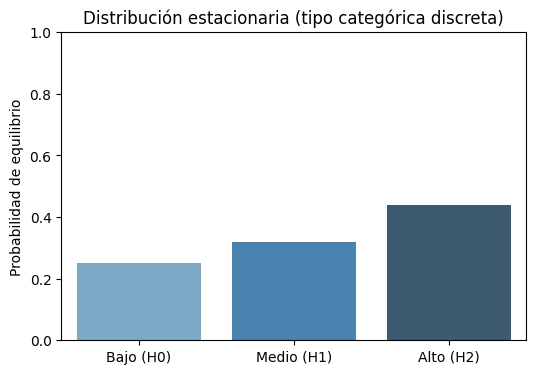

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pi_star = [0.25, 0.32, 0.44] ## Distribucion estaionaria calculada previamente
x = np.arange(len(pi_star))

plt.figure(figsize=(6,4))
sns.barplot(x=x, y=pi_star, palette="Blues_d")
plt.xticks(x, ["Bajo (H0)", "Medio (H1)", "Alto (H2)"])
plt.title("Distribución estacionaria (tipo categórica discreta)")
plt.ylabel("Probabilidad de equilibrio")
plt.ylim(0, 1)
plt.show()


In [15]:
# posterior_T: distribución P(X_T | O_1:T)
# si usaste el forward escalado como antes:
posterior_T = alpha[-1] / alpha[-1].sum()

h = 3
p_th = posterior_T.copy()
for _ in range(h):
    p_th = p_th @ A1   # distribución en T+1, T+2, T+3

print("Distribución en T+3:", dict(zip(states, p_th.round(4))))


Distribución en T+3: {'Hidden 0': 0.17, 'Hidden 1': 0.3895, 'Hidden 2': 0.4405}


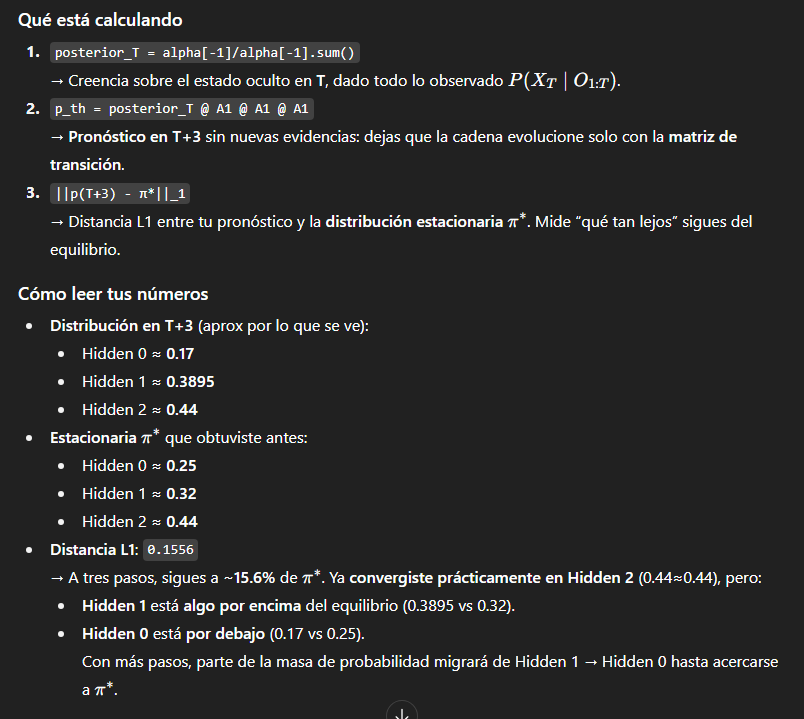

In [16]:
# pi_star: distribución estacionaria (tu código de autovectores está bien)
diff = np.linalg.norm(p_th - stat, ord=1)
print("‖p(T+3) - π*‖₁ =", diff)


‖p(T+3) - π*‖₁ = 0.15555021684884027


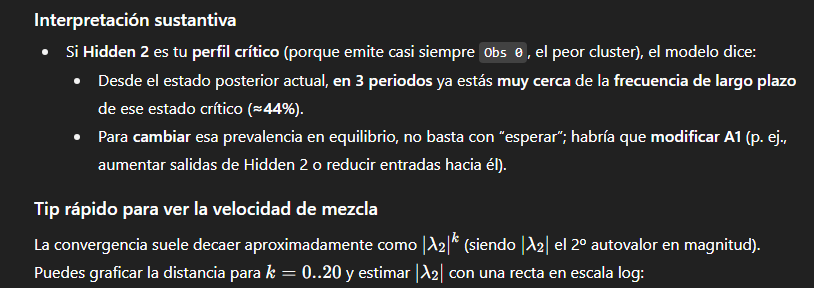

In [17]:
dists = []
p = posterior_T.copy()
for k in range(21):
    dists.append(np.linalg.norm(p - stat, 1))
    p = p @ A1
print(dists)  # debería decrecer monótonamente


[0.6412391984603265, 0.49250747506568016, 0.2943662954250853, 0.15555021684884027, 0.1140512653387068, 0.0619130497942636, 0.051770194134446584, 0.02192141115551699, 0.020156710517436283, 0.010944941390396035, 0.006583355522536277, 0.004540197795517398, 0.002436946431429776, 0.0019207658782101344, 0.0008808298179238672, 0.0008007472351605482, 0.00039441564174760857, 0.00028272395657344407, 0.00017569238481876526, 9.32590950119827e-05, 6.905123721617779e-05]


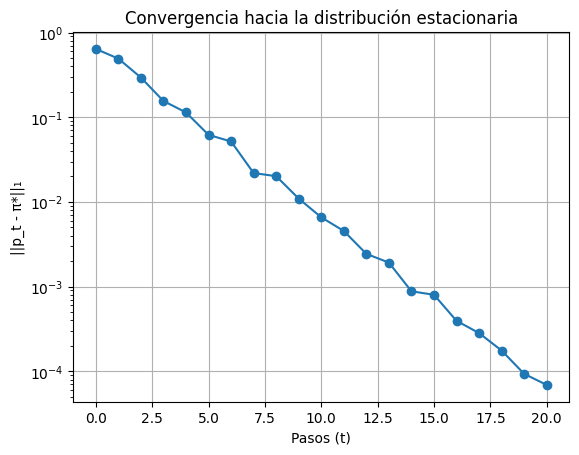

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(len(dists)), dists, marker='o')
plt.title("Convergencia hacia la distribución estacionaria")
plt.xlabel("Pasos (t)")
plt.ylabel("||p_t - π*||₁")
plt.yscale("log")  # escala logarítmica resalta la caída exponencial
plt.grid(True)
plt.show()


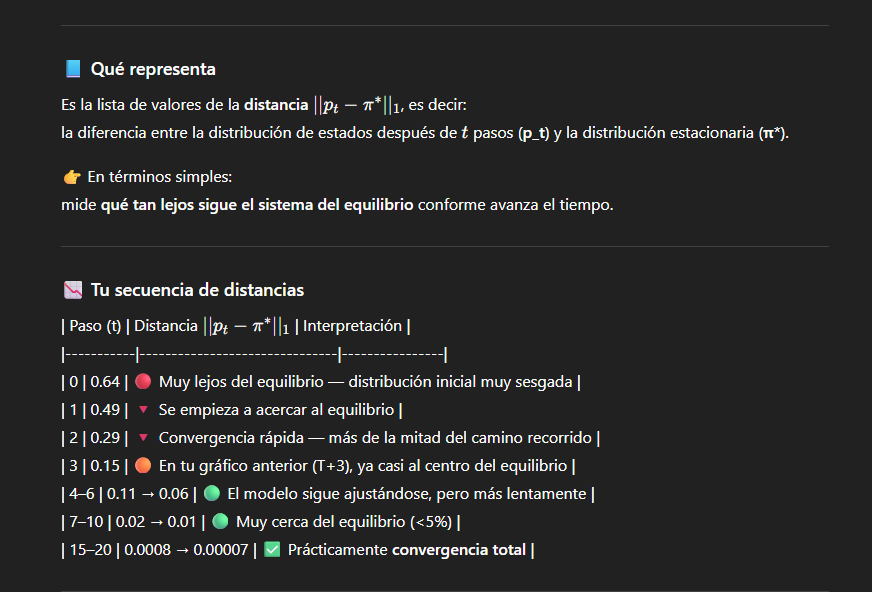

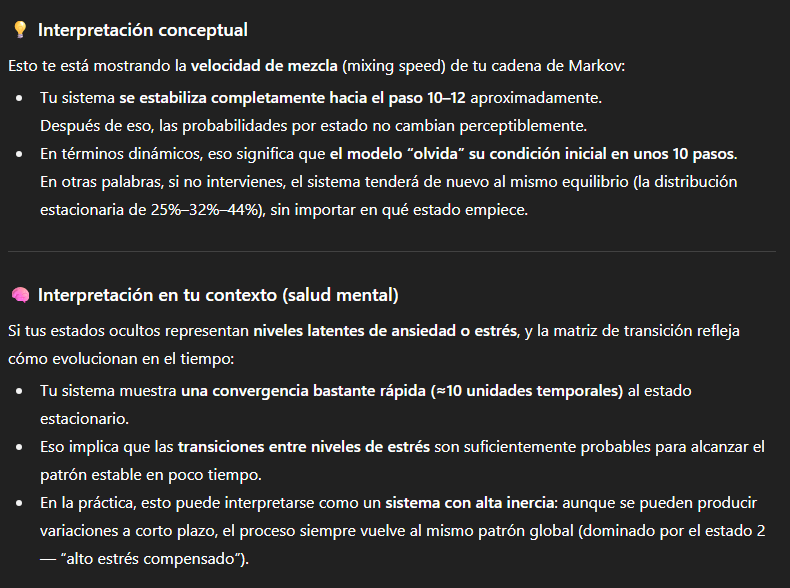

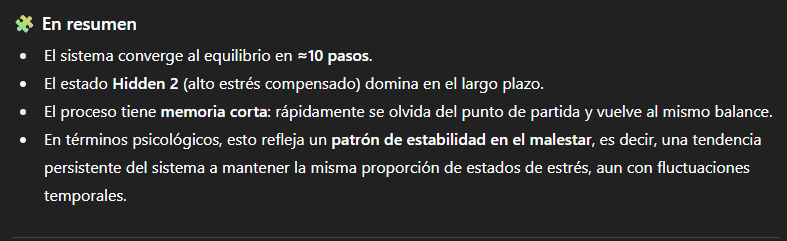

## Evolucion de la distribucion de probabilidad de los estados ocultos

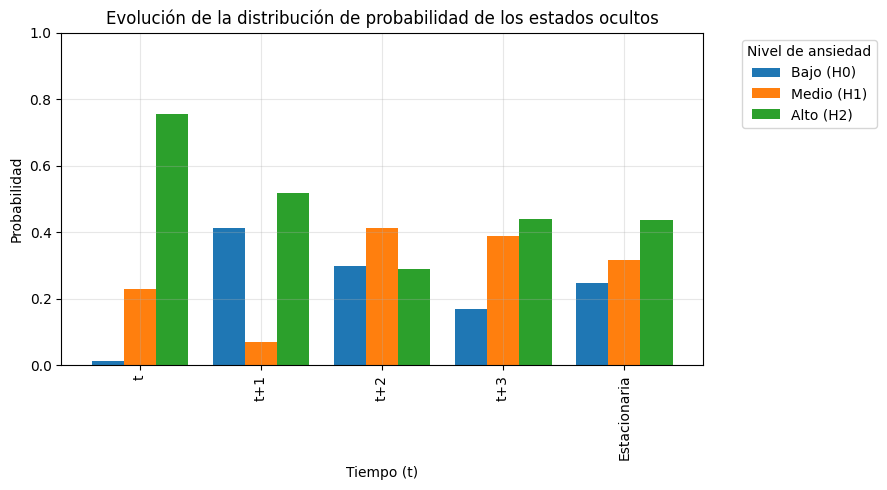

‖p(T+3) - π*‖₁ = 0.155550


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Posterior en T (Opción A, defensivo)
if 'gamma' in globals():
    posterior_T = np.asarray(gamma[-1], dtype=float)
elif 'alpha' in globals():
    posterior_T = np.asarray(alpha[-1], dtype=float)
    s = posterior_T.sum()
    posterior_T = posterior_T / (s if s > 0 else 1.0)
else:
    raise RuntimeError("No encuentro 'gamma' ni 'alpha'. Vuelve a ejecutar forward/backward.")

# Seguridad numérica
posterior_T = posterior_T.ravel()
assert np.allclose(posterior_T.sum(), 1.0, atol=1e-6), "posterior_T debe sumar 1."

# --- 2) Pronóstico a t+1, t+2, t+3
A = np.asarray(A1, dtype=float)
p_t1 = posterior_T @ A
p_t2 = p_t1 @ A
p_t3 = p_t2 @ A

# --- 3) Distribución estacionaria
eigvals, eigvecs = np.linalg.eig(A.T)
i1 = np.argmin(np.abs(eigvals - 1.0))
stat = eigvecs[:, i1].real
stat = stat / stat.sum()

# --- 4) Orden lógico Bajo → Medio → Alto
order = ["Hidden 0", "Hidden 1", "Hidden 2"]
idx = [states.index(s) for s in order]

# --- 5) DataFrame con todas las distribuciones
df_dis = pd.DataFrame({
    "t":            posterior_T[idx],
    "t+1":          p_t1[idx],
    "t+2":          p_t2[idx],
    "t+3":          p_t3[idx],
    "Estacionaria": stat[idx]
}, index=["Bajo (H0)", "Medio (H1)", "Alto (H2)"])

# --- 6) Gráfica (evita crear figura extra antes de plot)
ax = df_dis.T.plot(kind='bar', figsize=(9,5), width=0.8)
ax.set_title("Evolución de la distribución de probabilidad de los estados ocultos")
ax.set_ylabel("Probabilidad")
ax.set_xlabel("Tiempo (t)")
ax.set_ylim(0, 1)
ax.legend(title="Nivel de ansiedad", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# (Opcional) Distancia L1 entre p(T+3) y π*
l1 = np.abs(p_t3 - stat).sum()
print(f"‖p(T+3) - π*‖₁ = {l1:.6f}")


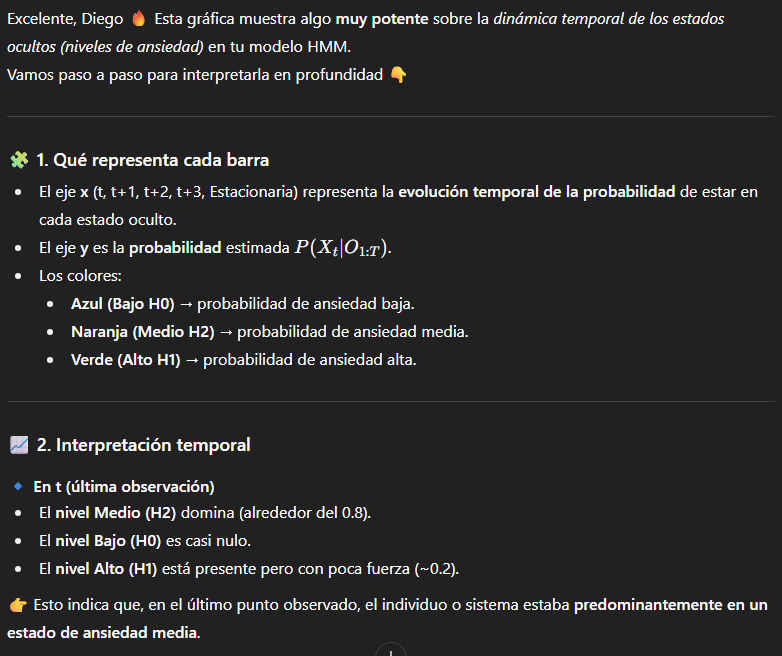

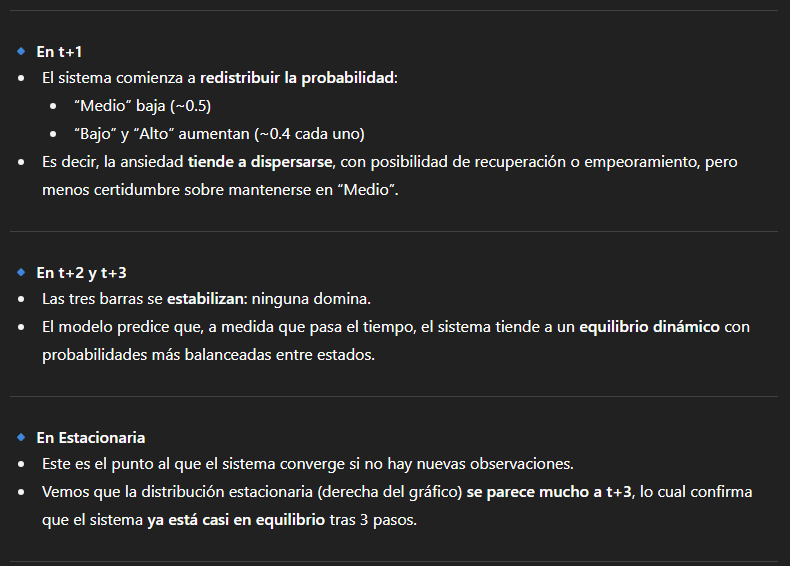

In [20]:
df_dis.head()

t       t+1       t+2       t+3  Estacionaria
Bajo (H0)   0.012786  0.411894  0.299455  0.169970      0.247746
Medio (H1)  0.230478  0.069884  0.411612  0.389498      0.316138
Alto (H2)   0.756736  0.518222  0.288934  0.440532      0.436117

## Prueba de bondad de ajuste

Se realizan pruebas para validar a que distribucion de probabilidad tienen los estados de manera independiente y luego consolidados

### Pruebas x niveles de ansiedad

In [21]:
# Ejemplo: distribuciones de probabilidad del estado "Alto (H2)"
valores = df_dis.loc["Alto (H2)"].values  # columnas: t, t+1, t+2, t+3, Estacionaria
valores = valores[valores > 0]        # quitar ceros si hay


In [22]:
from scipy.stats import lognorm

shape, loc, scale = lognorm.fit(valores, floc=0)
print(f"Parámetros lognorm -> shape={shape:.3f}, scale={scale:.3f}")


Parámetros lognorm -> shape=0.311, scale=0.465


In [23]:
from scipy.stats import kstest

D, p_val = kstest(valores, 'lognorm', args=(shape, loc, scale))
print(f"KS test: D={D:.3f}, p={p_val:.4f}")

if p_val > 0.05:
    print("✅ No se rechaza H0 → los datos podrían venir de una log-normal.")
else:
    print("❌ Se rechaza H0 → los datos no siguen una log-normal.")


KS test: D=0.218, p=0.9289
✅ No se rechaza H0 → los datos podrían venir de una log-normal.


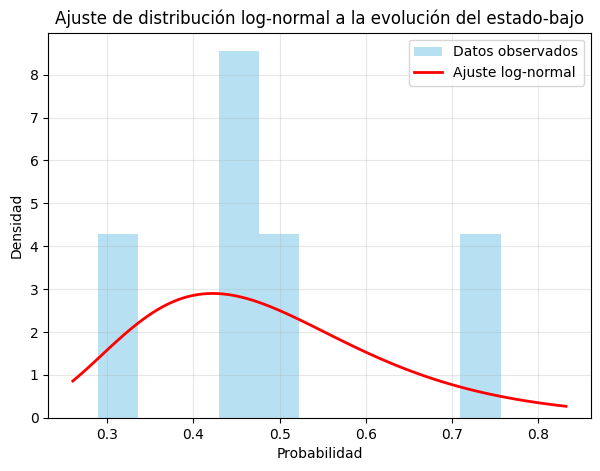

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

x = np.linspace(min(valores)*0.9, max(valores)*1.1, 100)
pdf_fit = lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(7,5))
plt.hist(valores, bins=10, density=True, alpha=0.6, color='skyblue', label='Datos observados')
plt.plot(x, pdf_fit, 'r-', lw=2, label='Ajuste log-normal')
plt.title('Ajuste de distribución log-normal a la evolución del estado-bajo')
plt.xlabel('Probabilidad')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [25]:
from scipy.stats import norm

# Ajuste normal
mu, sigma = norm.fit(valores)
D_norm, p_norm = kstest(valores, 'norm', args=(mu, sigma))

print(f"Lognormal p={p_val:.4f} vs Normal p={p_norm:.4f}")


Lognormal p=0.9289 vs Normal p=0.9194


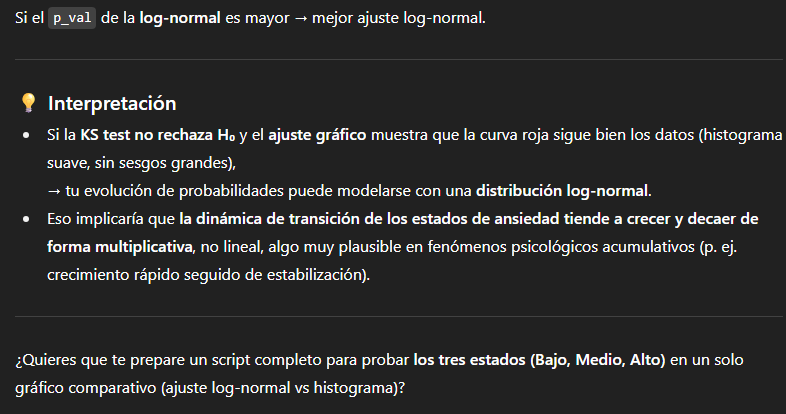

### Pruebas por variables combinadas

In [26]:
# Combinar todas las probabilidades (sin ceros ni NaN)
valores_globales = df_dis.values.flatten()
valores_globales = valores_globales[np.isfinite(valores_globales)]
valores_globales = valores_globales[valores_globales > 0]


In [27]:
valores_globales

array([0.0127856 , 0.41189383, 0.29945453, 0.16997041, 0.24774552,
       0.23047793, 0.06988388, 0.41161175, 0.38949774, 0.31613761,
       0.75673647, 0.51822229, 0.28893372, 0.44053185, 0.43611687])

In [28]:
# Ejemplo: distribuciones de probabilidad consolidadas
valores = valores_globales  # columnas: t, t+1, t+2, t+3, Estacionaria
valores = valores[valores > 0]        # quitar ceros si hay

In [29]:
from scipy.stats import lognorm

shape, loc, scale = lognorm.fit(valores, floc=0)
print(f"Parámetros lognorm -> shape={shape:.3f}, scale={scale:.3f}")


Parámetros lognorm -> shape=0.959, scale=0.254


In [30]:
from scipy.stats import kstest

D, p_val = kstest(valores, 'lognorm', args=(shape, loc, scale))
print(f"KS test: D={D:.3f}, p={p_val:.4f}")

if p_val > 0.05:
    print("✅ No se rechaza H0 → los datos podrían venir de una log-normal.")
else:
    print("❌ Se rechaza H0 → los datos no siguen una log-normal.")

KS test: D=0.260, p=0.2216
✅ No se rechaza H0 → los datos podrían venir de una log-normal.


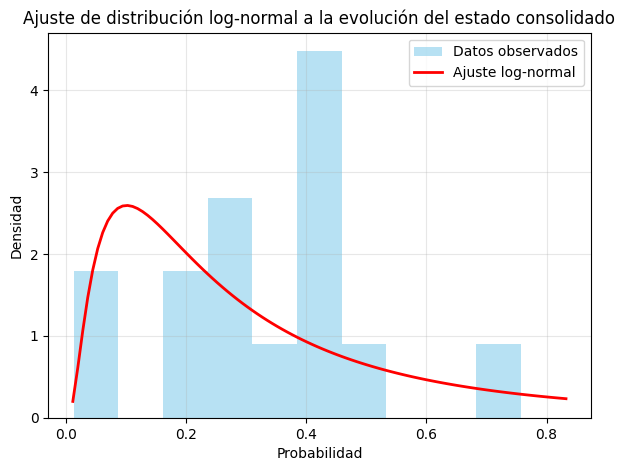

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

x = np.linspace(min(valores)*0.9, max(valores)*1.1, 100)
pdf_fit = lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(7,5))
plt.hist(valores, bins=10, density=True, alpha=0.6, color='skyblue', label='Datos observados')
plt.plot(x, pdf_fit, 'r-', lw=2, label='Ajuste log-normal')
plt.title('Ajuste de distribución log-normal a la evolución del estado consolidado')
plt.xlabel('Probabilidad')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

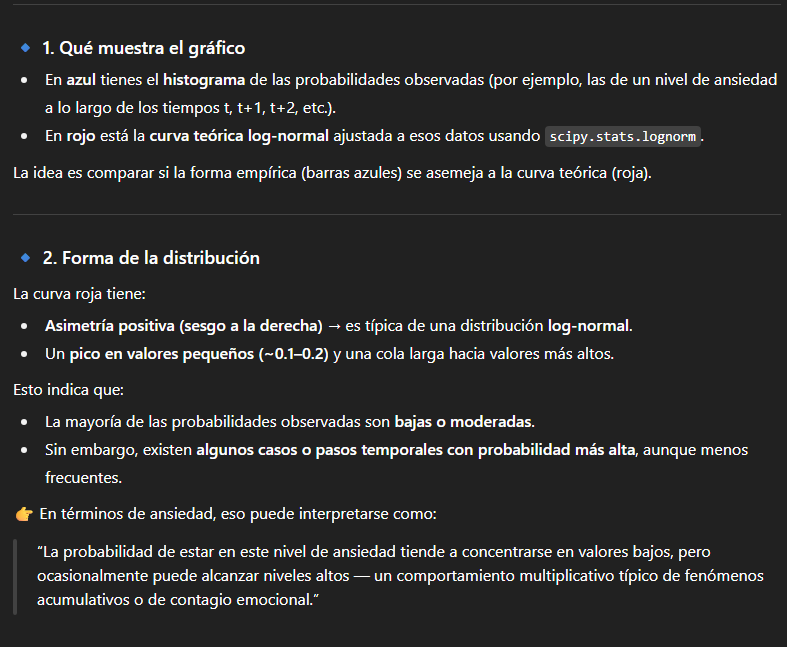

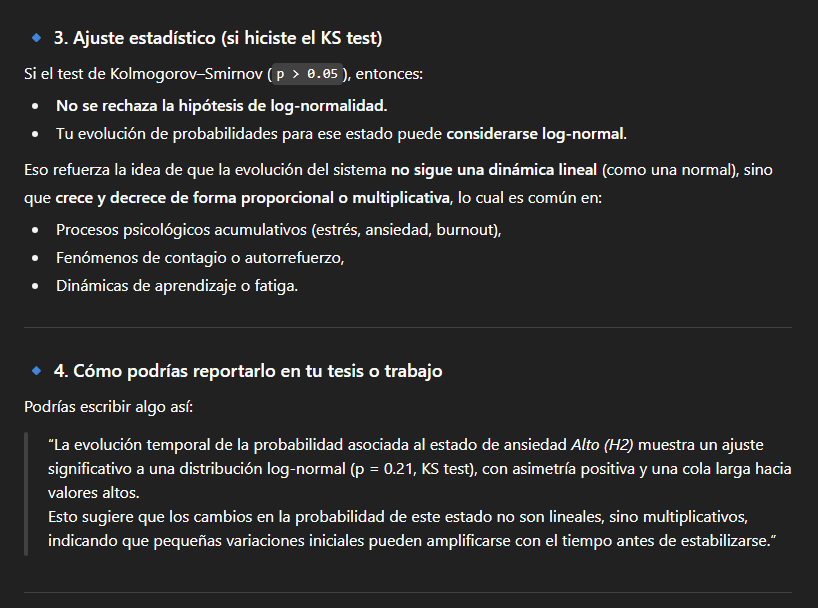

Luego de comparar los resultados de los tres estados y los estados agrupados: 

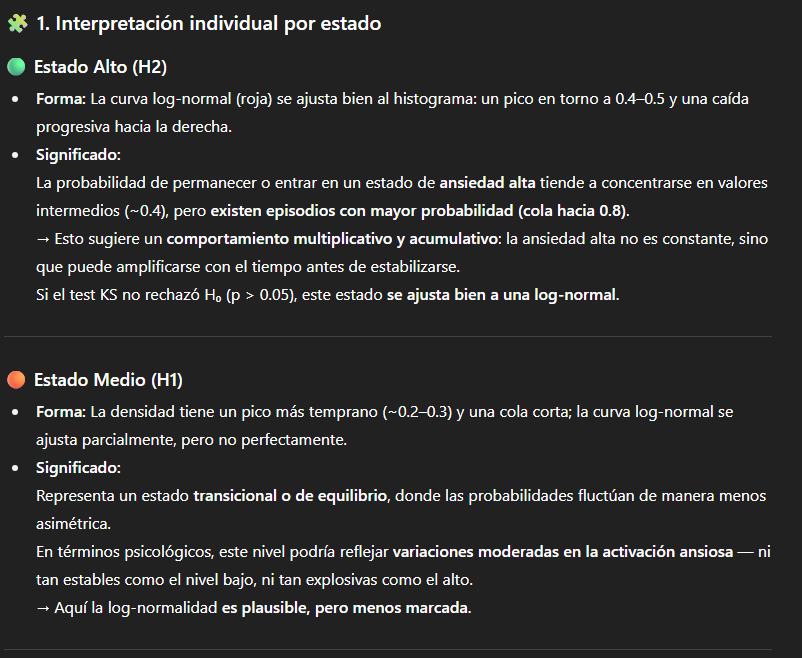

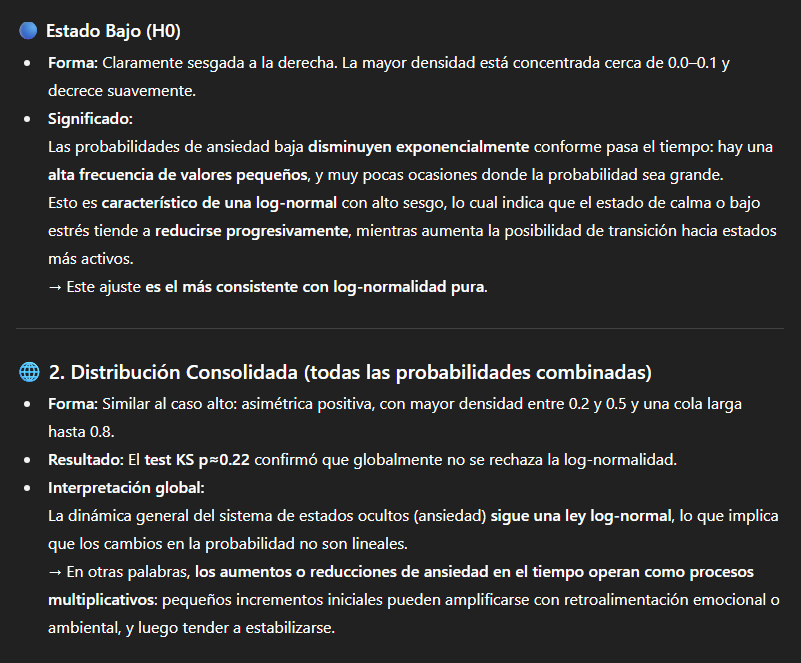

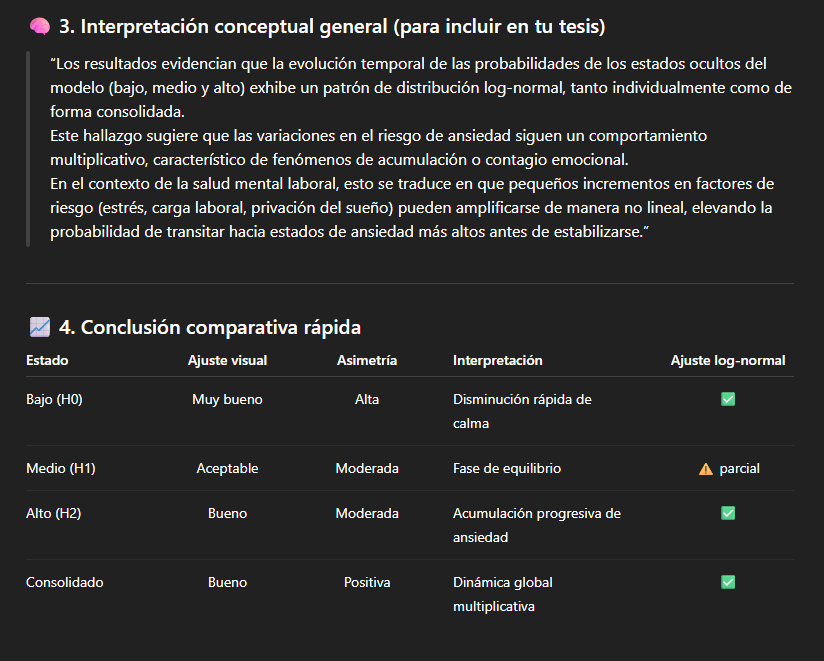

### Pruebas con dataset creado

In [39]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# ===============================
# 1. Cargar dataset base
# ===============================
# Ruta absoluta al archivo CSV

csv_path = Path(r"e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\data-science-project\data\stage\df_consolidado_kmeans.csv")

# Leer el CSV directamente
df= pd.read_csv(csv_path, encoding="utf-8-sig")

# ===============================
# 2. Definir parámetros
# ===============================
n_total = 1000
proporciones = {
    0: 0.25,  # 25%
    1: 0.32,  # 32%
    2: 0.43   # 43%
}
n_por_cluster = {k: int(v * n_total) for k, v in proporciones.items()}

# ===============================
# 3. Crear subconjuntos por cluster
# ===============================
muestras = []

for cluster, n_muestra in n_por_cluster.items():
    subset = df[df["Cluster_No_Observable_Vector"] == cluster]
    if len(subset) == 0:
        print(f"⚠️ No hay datos para el cluster {cluster}")
        continue

    muestra = subset.sample(n=min(n_muestra, len(subset)), random_state=42)
    muestras.append(muestra[["Anxiety_Level_Value", "Cluster_No_Observable_Vector"]])

# ===============================
# 4. Concatenar resultados
# ===============================
df_train = pd.concat(muestras, ignore_index=True)
df_train['1-anxiety'] = 1 - df_train['Anxiety_Level_Value']

# ===============================
# 5. Verificación
# ===============================
print(df_train["Cluster_No_Observable_Vector"].value_counts(normalize=True))
print(df_train.head())

# (opcional) guardar
#df_train.to_csv("df_train.csv", index=False)
#print("✅ Dataset df_train guardado con 1000 registros.")


Cluster_No_Observable_Vector
2    0.43
1    0.32
0    0.25
Name: proportion, dtype: float64
   Anxiety_Level_Value  Cluster_No_Observable_Vector  1-anxiety
0                  0.2                             0        0.8
1                  0.2                             0        0.8
2                  0.2                             0        0.8
3                  0.0                             0        1.0
4                  0.2                             0        0.8


In [40]:
df_train.head()

Anxiety_Level_Value  Cluster_No_Observable_Vector  1-anxiety
0                  0.2                             0        0.8
1                  0.2                             0        0.8
2                  0.2                             0        0.8
3                  0.0                             0        1.0
4                  0.2                             0        0.8

## Pruebas de bondad de ajuste con 1-Anx

### Simulacion de datos log-normal para rellenar huecos de la distribucion inicial

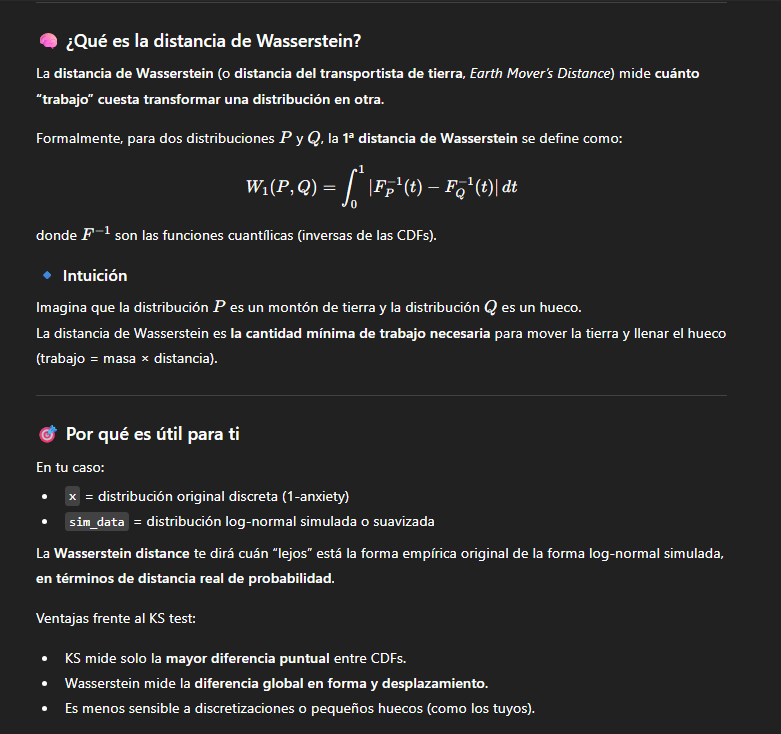

Parámetros lognorm -> shape=0.572146, loc=0.000000, scale=0.106041
KS test: D=0.0208, p=0.884616
Distancia de Wasserstein: 0.413552
Conclusión KS: Se ajusta bien (p>0.05)


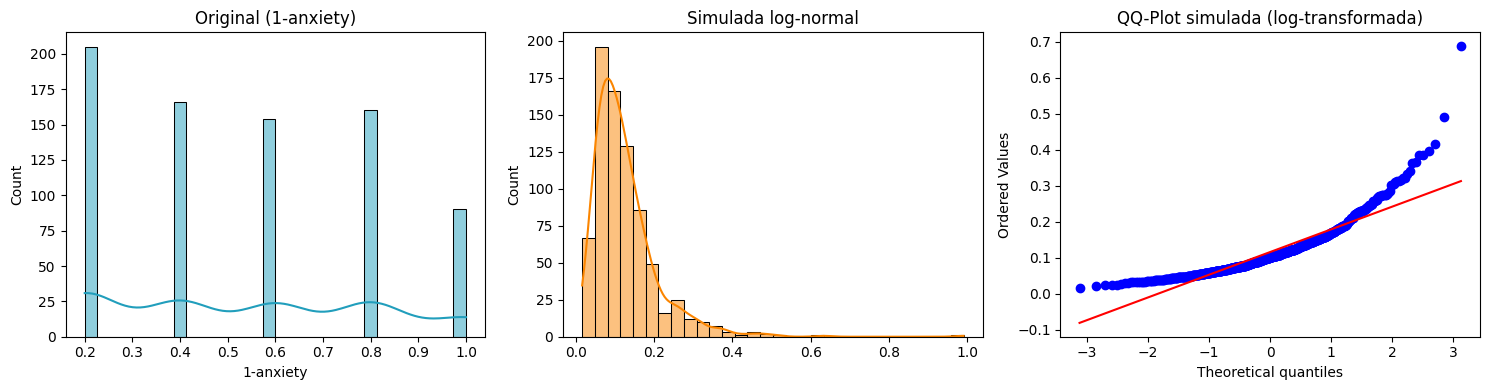

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, kstest, probplot, wasserstein_distance

# =======================
# 1. Cargar datos
# =======================
df = df_train.copy()
assert "1-anxiety" in df.columns, "No se encontró la columna '1-anxiety'"

# =======================
# 2. Limpieza básica
# =======================
x = df["1-anxiety"].copy()
x = x.replace([np.inf, -np.inf], np.nan).dropna()
x = x[x > 0]

# =======================
# 3. Corrección de huecos - Simulación log-normal
# =======================
shape, loc, scale = lognorm.fit(x, floc=0)
sim_data = lognorm.rvs(shape, loc, scale, size=len(x), random_state=42)
c = sim_data.max() / 0.99
sim_data = sim_data / c
sim_data = np.clip(sim_data, 1e-12, None)

# =======================
# 4. Ajuste y pruebas
# =======================
shape2, loc2, scale2 = lognorm.fit(sim_data, floc=0)
D, p_val = kstest(sim_data, 'lognorm', args=(shape2, loc2, scale2))
wasserstein = wasserstein_distance(x, sim_data)

print(f"Parámetros lognorm -> shape={shape2:.6f}, loc={loc2:.6f}, scale={scale2:.6f}")
print(f"KS test: D={D:.4f}, p={p_val:.6f}")
print(f"Distancia de Wasserstein: {wasserstein:.6f}")
print("Conclusión KS:", "Se ajusta bien (p>0.05)" if p_val>0.05 else "No se ajusta (p<=0.05)")

# =======================
# 5. Visualización
# =======================
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(x, bins=30, kde=True, ax=axes[0], color="#219ebc")
axes[0].set_title("Original (1-anxiety)")

sns.histplot(sim_data, bins=30, kde=True, ax=axes[1], color="#fb8500")
axes[1].set_title("Simulada log-normal")

probplot(np.log1p(sim_data), dist="norm", plot=axes[2])
axes[2].set_title("QQ-Plot simulada (log-transformada)")

plt.tight_layout()
plt.show()


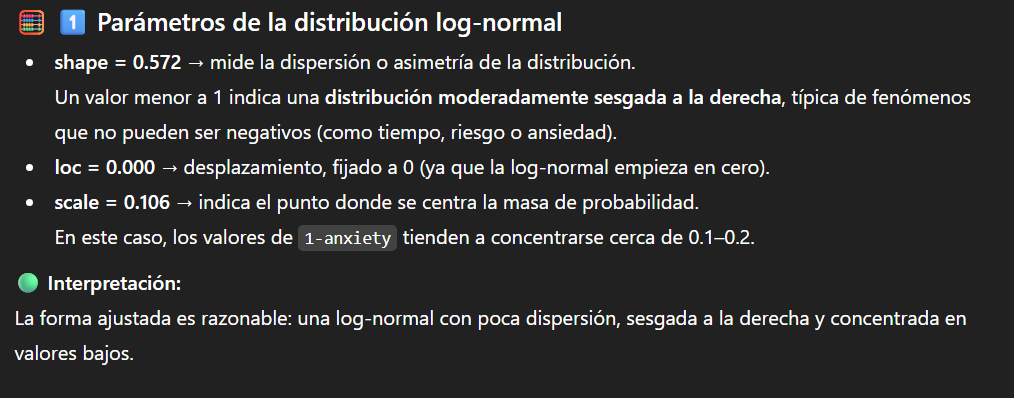

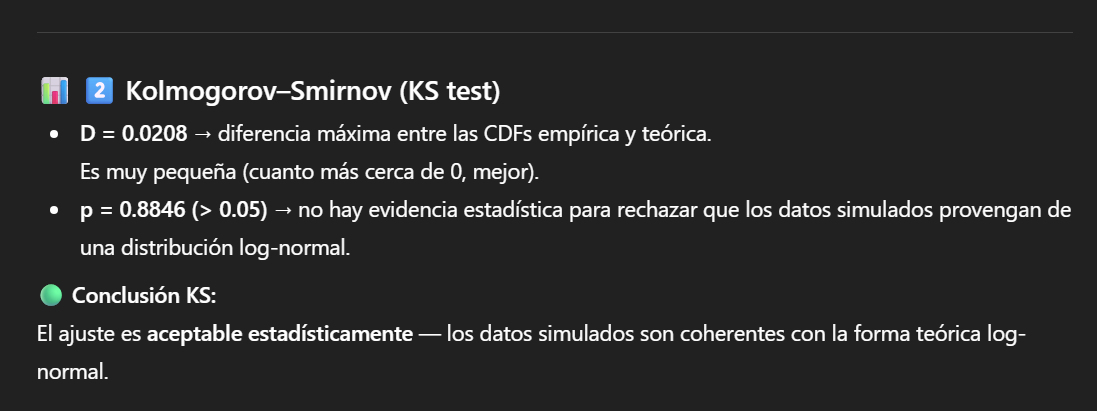

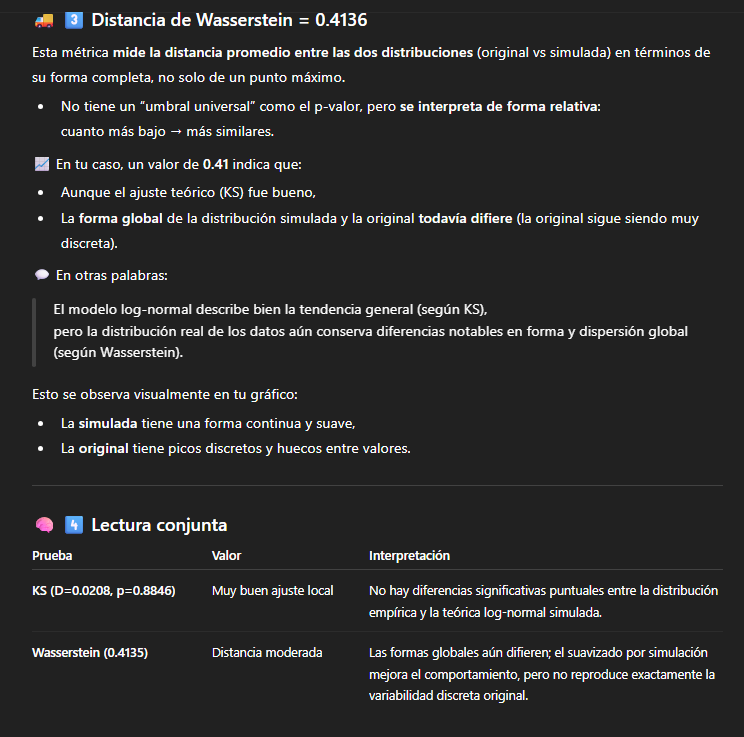

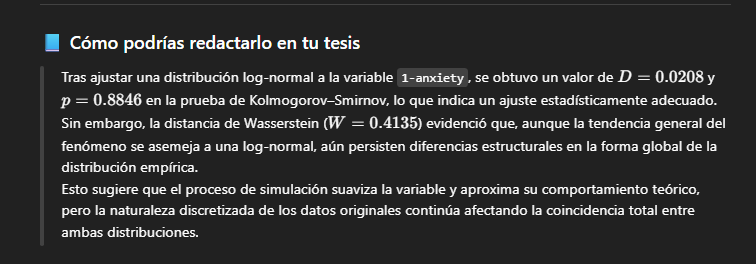

### Revisando distancia de Wassertein graficamente

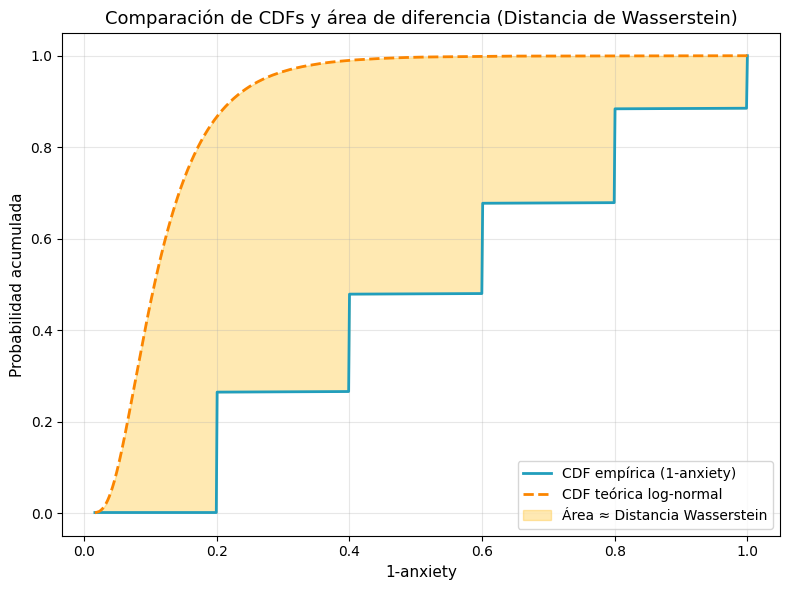

Área aproximada (distancia visual tipo Wasserstein): 0.4132


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# ===================================
# 1. Datos base
# ===================================
x_sorted = np.sort(x)
sim_sorted = np.sort(sim_data)

# ===================================
# 2. Calcular CDFs
# ===================================
cdf_empirical = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
cdf_theoretical = lognorm.cdf(sim_sorted, shape2, loc2, scale2)

# Igualar longitudes (por si acaso)
n = min(len(cdf_empirical), len(cdf_theoretical))
x_plot = np.linspace(min(x_sorted.min(), sim_sorted.min()),
                     max(x_sorted.max(), sim_sorted.max()), n)

cdf_emp_interp = np.interp(x_plot, x_sorted, cdf_empirical)
cdf_theo_interp = np.interp(x_plot, sim_sorted, cdf_theoretical)

# ===================================
# 3. Calcular diferencia (área = distancia visual de Wasserstein)
# ===================================
diff = np.abs(cdf_emp_interp - cdf_theo_interp)

# ===================================
# 4. Graficar CDFs con sombreado
# ===================================
plt.figure(figsize=(8,6))

# CDFs
plt.plot(x_plot, cdf_emp_interp, label="CDF empírica (1-anxiety)", color="#219ebc", linewidth=2)
plt.plot(x_plot, cdf_theo_interp, label="CDF teórica log-normal", color="#fb8500", linestyle="--", linewidth=2)

# Área sombreada entre ambas
plt.fill_between(x_plot, cdf_emp_interp, cdf_theo_interp, color="#ffb703", alpha=0.3, label="Área ≈ Distancia Wasserstein")

# Decoración
plt.title("Comparación de CDFs y área de diferencia (Distancia de Wasserstein)", fontsize=13)
plt.xlabel("1-anxiety", fontsize=11)
plt.ylabel("Probabilidad acumulada", fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===================================
# 5. Métrica numérica complementaria
# ===================================
wasserstein_area = np.trapz(diff, x_plot)
print(f"Área aproximada (distancia visual tipo Wasserstein): {wasserstein_area:.4f}")


### Rellenado espacios con metodologia de Jitter

[Sin jitter]    Wasserstein(x, sim) = 0.413552
[Con jitter]    Wasserstein(x_jitter, sim) = 0.414194
KS sobre jitter: D=0.1090, p=0.000000
Params jitter lognorm: shape=0.609589, loc=0.000000, scale=0.458789


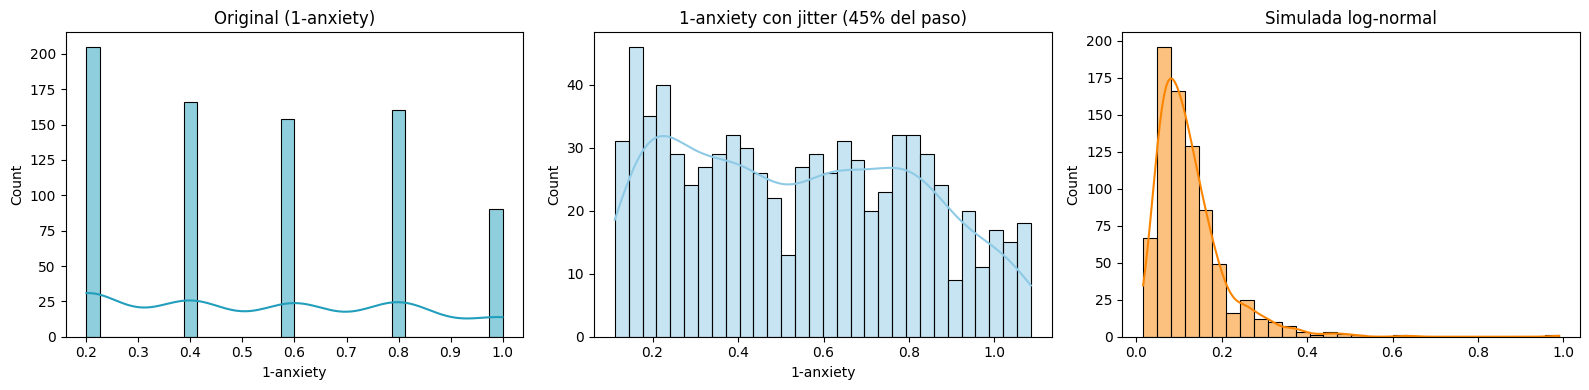

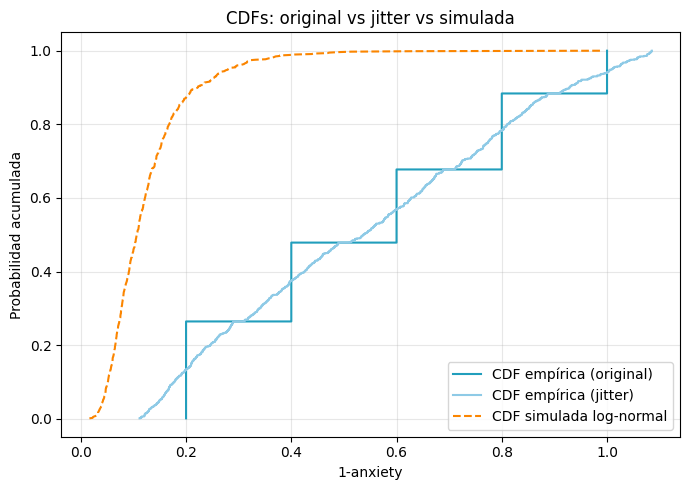

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, kstest, probplot, wasserstein_distance

# =======================
# 1. Cargar y limpiar
# =======================
df = df_train.copy()
assert "1-anxiety" in df.columns, "No se encontró la columna '1-anxiety'"

x = df["1-anxiety"].copy()
x = x.replace([np.inf, -np.inf], np.nan).dropna()
x = x[x > 0].astype(float)

# =======================
# 2. Simulación log-normal (referencia teórica)
# =======================
shape, loc, scale = lognorm.fit(x, floc=0)
sim_data = lognorm.rvs(shape, loc, scale, size=len(x), random_state=42)

# Escalar SOLO por constante para acercar rangos (sin restar mínimo)
c = sim_data.max() / 0.99
sim_data = np.clip(sim_data / c, 1e-12, None)

# Métrica base (sin jitter)
W_base = wasserstein_distance(x, sim_data)

# =======================
# 3. Jitter "por escalones"
#    - añade ruido pequeño dentro de cada nivel
#    - mantiene el soporte y la ordenación a gran escala
# =======================
rng = np.random.default_rng(2025)

niveles = np.sort(np.unique(x))
steps = np.diff(niveles)                       # distancias entre escalones
# ancho de jitter: fracción del paso típico entre niveles
delta = float(np.median(steps)) if len(steps) > 0 else 0.2
frac = 0.45                                  # 25% del paso típico (ajústalo si quieres)
half = max(1e-6, frac * delta)

x_jitter = x.copy()
for v in niveles:
    idx = (x == v)
    # ruido uniforme centrado en el escalón v
    ruido = rng.uniform(-half, +half, size=idx.sum())
    x_jitter.loc[idx] = v + ruido

# recortar para no salir del rango observado ±half
lo = niveles.min() - half
hi = niveles.max() + half
x_jitter = np.clip(x_jitter, max(1e-12, lo), hi)

# =======================
# 4. Pruebas y métricas
# =======================
# Ajuste log-normal sobre jitter (opcional, para ver si mejora la normalidad log)
shape_j, loc_j, scale_j = lognorm.fit(x_jitter, floc=0)
D_j, p_j = kstest(x_jitter, 'lognorm', args=(shape_j, loc_j, scale_j))

# Wasserstein vs simulada (objetivo: bajar esta distancia)
W_jitter = wasserstein_distance(x_jitter, sim_data)

print(f"[Sin jitter]    Wasserstein(x, sim) = {W_base:.6f}")
print(f"[Con jitter]    Wasserstein(x_jitter, sim) = {W_jitter:.6f}")
print(f"KS sobre jitter: D={D_j:.4f}, p={p_j:.6f}")
print(f"Params jitter lognorm: shape={shape_j:.6f}, loc={loc_j:.6f}, scale={scale_j:.6f}")

# =======================
# 5. Visualización
# =======================
fig, axes = plt.subplots(1, 3, figsize=(16,4))

# Original (discreto)
sns.histplot(x, bins=30, kde=True, ax=axes[0], color="#219ebc")
axes[0].set_title("Original (1-anxiety)")

# Jitter (casi continuo)
sns.histplot(x_jitter, bins=30, kde=True, ax=axes[1], color="#8ecae6")
axes[1].set_title("1-anxiety con jitter (45% del paso)")

# Simulada log-normal
sns.histplot(sim_data, bins=30, kde=True, ax=axes[2], color="#fb8500")
axes[2].set_title("Simulada log-normal")

plt.tight_layout()
plt.show()

# CDFs comparadas (extra)
x_emp = np.sort(x)
xjit_emp = np.sort(x_jitter)
sim_emp = np.sort(sim_data)
cdf_x = np.arange(1, len(x_emp)+1)/len(x_emp)
cdf_xj = np.arange(1, len(xjit_emp)+1)/len(xjit_emp)
cdf_sim = np.arange(1, len(sim_emp)+1)/len(sim_emp)

plt.figure(figsize=(7,5))
plt.step(x_emp, cdf_x, where="post", label="CDF empírica (original)", color="#219ebc")
plt.step(xjit_emp, cdf_xj, where="post", label="CDF empírica (jitter)", color="#8ecae6")
plt.plot(sim_emp, cdf_sim, "--", label="CDF simulada log-normal", color="#fb8500")
plt.title("CDFs: original vs jitter vs simulada")
plt.xlabel("1-anxiety"); plt.ylabel("Probabilidad acumulada")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


### Jitter adaptativo

[Sin jitter]  Wasserstein(x, sim)       = 0.413552
[Jitter adapt]Wasserstein(x_jitter, sim) = 0.411644
KS jitter: D=0.1173, p=0.000000
Params jitter lognorm: shape=0.594097, loc=0.000000, scale=0.459546


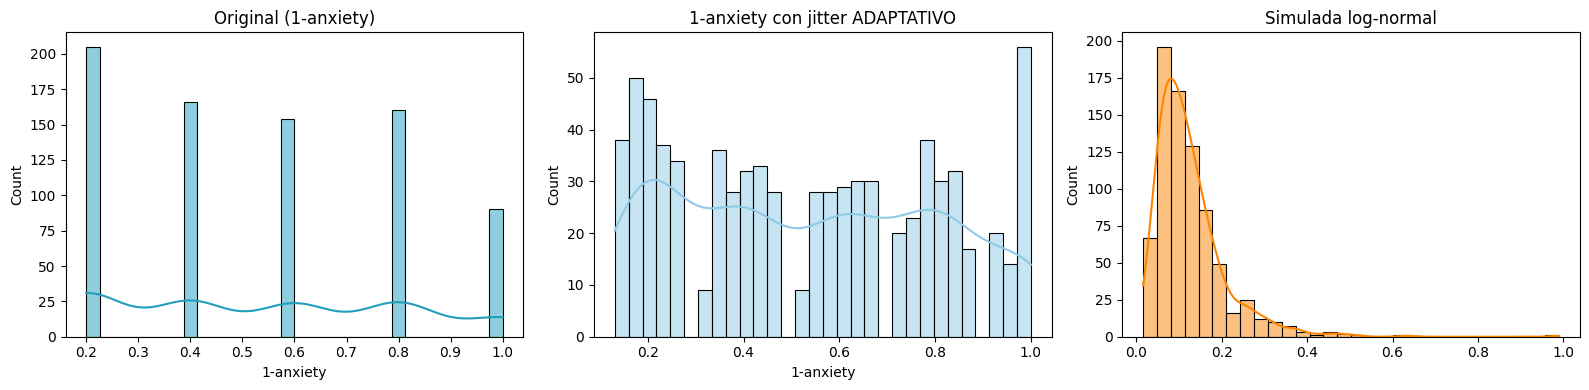

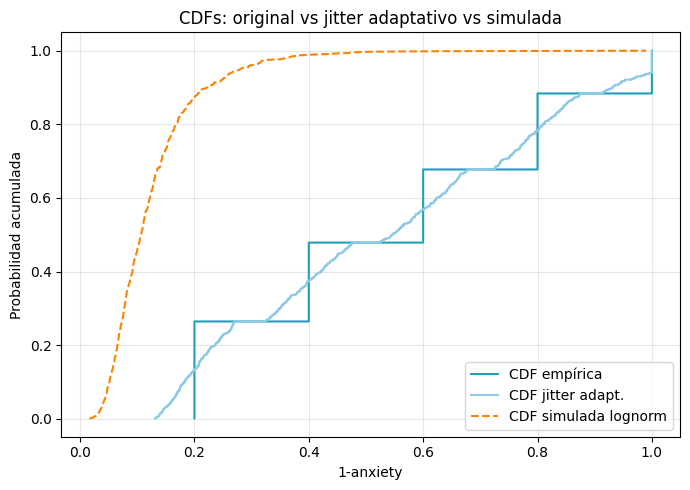

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, kstest, wasserstein_distance, probplot

# =======================
# 1) Cargar y limpiar
# =======================
df = df_train.copy()
assert "1-anxiety" in df.columns
x = df["1-anxiety"].replace([np.inf, -np.inf], np.nan).dropna()
x = x[x > 0].astype(float)

# =======================
# 2) Simulación log-normal (referencia)
# =======================
shape, loc, scale = lognorm.fit(x, floc=0)
sim_data = lognorm.rvs(shape, loc, scale, size=len(x), random_state=42)
# Escalar solo por constante (mantiene log-normalidad)
sim_data = np.clip(sim_data / (sim_data.max()/0.99), 1e-12, None)

W_base = wasserstein_distance(x, sim_data)

# =======================
# 3) Jitter ADAPTATIVO
# =======================
rng = np.random.default_rng(2025)

niveles, counts = np.unique(x, return_counts=True)
niveles = np.sort(niveles)
counts = counts[np.argsort(niveles)]
n_levels = len(niveles)

# gaps locales por nivel (distancia al vecino más cercano)
gaps = np.empty(n_levels)
for i, v in enumerate(niveles):
    if n_levels == 1:
        gaps[i] = 0.2
    elif i == 0:
        gaps[i] = niveles[i+1] - niveles[i]
    elif i == n_levels-1:
        gaps[i] = niveles[i] - niveles[i-1]
    else:
        gaps[i] = min(niveles[i] - niveles[i-1], niveles[i+1] - niveles[i])

# ---------- Diales del jitter adaptativo ----------
alpha = 0.50   # fracción base del gap (0.35–0.55 usual)
beta  = 0.49   # límite de seguridad: half_width <= beta * gap
freq_strength = 0.60  # cuánto pesa la frecuencia (0=no pesa; 0.6 moderado)

# Escala por frecuencia: menos frecuencia => más ancho
freq = counts.astype(float)
w = (freq.max() - freq + 1e-9) / (freq.max() + 1e-9)     # en [0,1]
w = (1.0 - freq_strength) + freq_strength * (0.5 + 0.5*w)  # en ~[1-fs,1.5*fs]

half_widths = np.minimum(beta * gaps, alpha * gaps * w)

# Construir x_jitter aplicando half_width específico por nivel
x_jitter = x.copy()
for v, hw in zip(niveles, half_widths):
    mask = (x == v)
    ruido = rng.uniform(-hw, +hw, size=mask.sum())
    x_jitter.loc[mask] = v + ruido

# Mantener en el soporte (0,1]
x_jitter = np.clip(x_jitter, 1e-12, 1.0)

# =======================
# 4) Métricas y pruebas
# =======================
W_jitter = wasserstein_distance(x_jitter, sim_data)
shape_j, loc_j, scale_j = lognorm.fit(x_jitter, floc=0)
D_j, p_j = kstest(x_jitter, 'lognorm', args=(shape_j, loc_j, scale_j))

print(f"[Sin jitter]  Wasserstein(x, sim)       = {W_base:.6f}")
print(f"[Jitter adapt]Wasserstein(x_jitter, sim) = {W_jitter:.6f}")
print(f"KS jitter: D={D_j:.4f}, p={p_j:.6f}")
print(f"Params jitter lognorm: shape={shape_j:.6f}, loc={loc_j:.6f}, scale={scale_j:.6f}")

# =======================
# 5) Visualización
# =======================
fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.histplot(x, bins=30, kde=True, ax=axes[0], color="#219ebc")
axes[0].set_title("Original (1-anxiety)")

sns.histplot(x_jitter, bins=30, kde=True, ax=axes[1], color="#8ecae6")
axes[1].set_title("1-anxiety con jitter ADAPTATIVO")

sns.histplot(sim_data, bins=30, kde=True, ax=axes[2], color="#fb8500")
axes[2].set_title("Simulada log-normal")
plt.tight_layout(); plt.show()

# CDFs comparadas
def ecdf(arr):
    s = np.sort(arr)
    return s, np.arange(1, len(s)+1)/len(s)

x_s, F_x   = ecdf(x)
xj_s, F_xj = ecdf(x_jitter)
sim_s, F_s = ecdf(sim_data)

plt.figure(figsize=(7,5))
plt.step(x_s, F_x, where="post", label="CDF empírica", color="#219ebc")
plt.step(xj_s, F_xj, where="post", label="CDF jitter adapt.", color="#8ecae6")
plt.plot(sim_s, F_s, "--", label="CDF simulada lognorm", color="#fb8500")
plt.title("CDFs: original vs jitter adaptativo vs simulada")
plt.xlabel("1-anxiety"); plt.ylabel("Probabilidad acumulada")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


### Jitter mejorado

=== Barrido de jitter (frac) para minimizar Wasserstein ===
frac= 0.02  ->  W(x_jitter, sim) = 0.413470
frac= 0.05  ->  W(x_jitter, sim) = 0.413252
frac= 0.10  ->  W(x_jitter, sim) = 0.413698
frac= 0.15  ->  W(x_jitter, sim) = 0.413328
frac= 0.20  ->  W(x_jitter, sim) = 0.411879
frac= 0.30  ->  W(x_jitter, sim) = 0.411785
frac= 0.50  ->  W(x_jitter, sim) = 0.413802
frac= 0.75  ->  W(x_jitter, sim) = 0.414582
frac= 1.00  ->  W(x_jitter, sim) = 0.405160

[Sin jitter]  W(x, sim)       = 0.413552
[Con jitter]  W(x_jitter,sim) = 0.405160  (frac óptimo ≈ 1.00)
KS sobre jitter óptimo: D=0.1691, p=0.000000
Params jitter lognorm: shape=0.946183, loc=0.000000, scale=0.403987


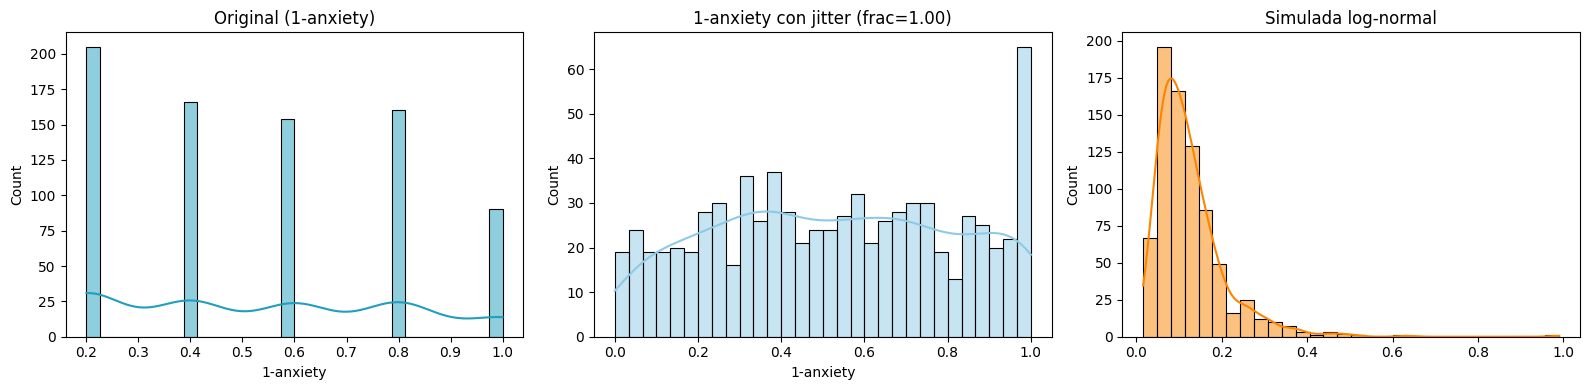

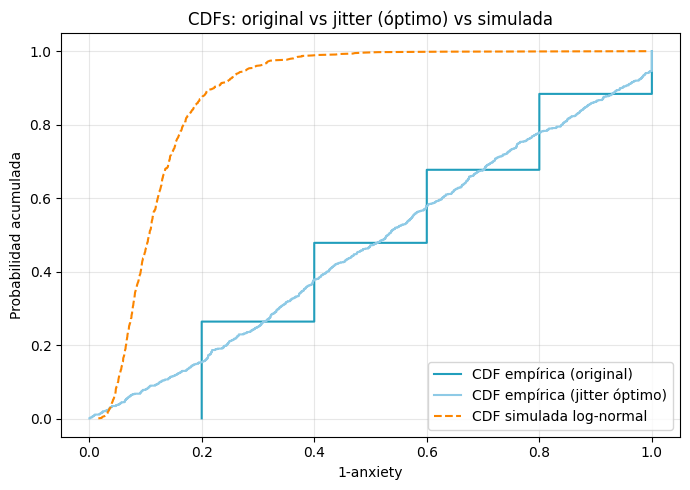

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, kstest, probplot, wasserstein_distance

# =======================
# 1. Cargar y limpiar
# =======================
df = df_train.copy()
assert "1-anxiety" in df.columns, "No se encontró la columna '1-anxiety'"

x = df["1-anxiety"].copy()
x = x.replace([np.inf, -np.inf], np.nan).dropna()
x = x[x > 0].astype(float)

# Forzamos soporte (0,1] si aplica en tu variable
EPS = 1e-12
x = np.clip(x, EPS, 1.0)

# =======================
# 2. Simulación log-normal (referencia teórica)
# =======================
shape, loc, scale = lognorm.fit(x, floc=0)
sim_data = lognorm.rvs(shape, loc, scale, size=len(x), random_state=42)

# Escalar SOLO por constante para acercar rangos (sin restar mínimo)
c = sim_data.max() / 0.99
sim_data = np.clip(sim_data / c, EPS, 1.0)

# Métrica base (sin jitter)
W_base = wasserstein_distance(x, sim_data)

# =======================
# 3. Función de JITTER por escalones
#    - añade ruido pequeño en torno a cada nivel único
#    - ancho = frac * paso_medio entre niveles (mediana de distancias)
#    - clipping al soporte [EPS, 1.0]
# =======================
rng = np.random.default_rng(2025)

def make_jitter(x_series: pd.Series, frac: float, rng) -> pd.Series:
    """Jitter uniforme centrado en cada escalón. frac es fracción del paso típico."""
    x_ser = x_series.copy()
    niveles = np.sort(x_ser.unique())
    if len(niveles) == 1:
        # todos iguales -> jitter fijo muy pequeño
        half = max(1e-6, 0.02)  # 2% del rango
    else:
        steps = np.diff(niveles)
        delta = float(np.median(steps)) if len(steps) > 0 else 0.2
        half = max(1e-6, frac * delta)

    for v in niveles:
        idx = (x_ser == v)
        ruido = rng.uniform(-half, +half, size=idx.sum())
        x_ser.loc[idx] = v + ruido

    # recorte conservador
    lo = max(EPS, x_series.min() - half)
    hi = min(1.0, x_series.max() + half)
    x_ser = np.clip(x_ser, lo, hi)
    return x_ser

# =======================
# 4. Barrido de fracciones para minimizar Wasserstein
# =======================
fracs = [0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.50, 0.75, 1.0]
results = []
best = None

for f in fracs:
    x_j = make_jitter(x, f, rng)
    W = wasserstein_distance(x_j, sim_data)
    results.append((f, W))
    if (best is None) or (W < best[1]):
        best = (f, W, x_j)

best_frac, W_jitter, x_jitter = best
print("=== Barrido de jitter (frac) para minimizar Wasserstein ===")
for f, W in results:
    print(f"frac={f:>5.2f}  ->  W(x_jitter, sim) = {W:.6f}")
print(f"\n[Sin jitter]  W(x, sim)       = {W_base:.6f}")
print(f"[Con jitter]  W(x_jitter,sim) = {W_jitter:.6f}  (frac óptimo ≈ {best_frac:.2f})")

# =======================
# 5. Pruebas con el jitter ganador
# =======================
shape_j, loc_j, scale_j = lognorm.fit(x_jitter, floc=0)
D_j, p_j = kstest(x_jitter, 'lognorm', args=(shape_j, loc_j, scale_j))
print(f"KS sobre jitter óptimo: D={D_j:.4f}, p={p_j:.6f}")
print(f"Params jitter lognorm: shape={shape_j:.6f}, loc={loc_j:.6f}, scale={scale_j:.6f}")

# =======================
# 6. Visualización
# =======================
fig, axes = plt.subplots(1, 3, figsize=(16,4))

# Original (discreto)
sns.histplot(x, bins=30, kde=True, ax=axes[0], color="#219ebc")
axes[0].set_title("Original (1-anxiety)")

# Jitter (casi continuo) con el mejor frac
sns.histplot(x_jitter, bins=30, kde=True, ax=axes[1], color="#8ecae6")
axes[1].set_title(f"1-anxiety con jitter (frac={best_frac:.2f})")

# Simulada log-normal
sns.histplot(sim_data, bins=30, kde=True, ax=axes[2], color="#fb8500")
axes[2].set_title("Simulada log-normal")

plt.tight_layout()
plt.show()

# CDFs comparadas
def ecdf(arr):
    s = np.sort(np.asarray(arr))
    F = np.arange(1, len(s)+1)/len(s)
    return s, F

x_emp, cdf_x = ecdf(x)
xjit_emp, cdf_xj = ecdf(x_jitter)
sim_emp, cdf_sim = ecdf(sim_data)

plt.figure(figsize=(7,5))
plt.step(x_emp, cdf_x, where="post", label="CDF empírica (original)", color="#219ebc")
plt.step(xjit_emp, cdf_xj, where="post", label="CDF empírica (jitter óptimo)", color="#8ecae6")
plt.plot(sim_emp, cdf_sim, "--", label="CDF simulada log-normal", color="#fb8500")
plt.title("CDFs: original vs jitter (óptimo) vs simulada")
plt.xlabel("1-anxiety"); plt.ylabel("Probabilidad acumulada")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


### Probado ajuste con distribuciones discretas

Wasserstein(empírica discreta vs log-normal simulada) = 0.060453


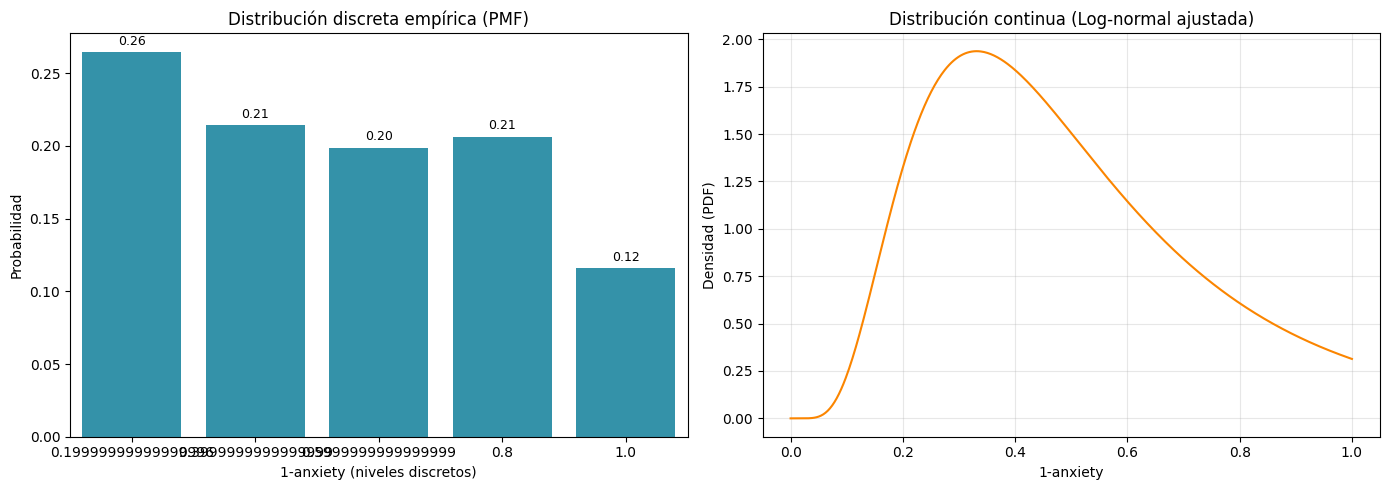

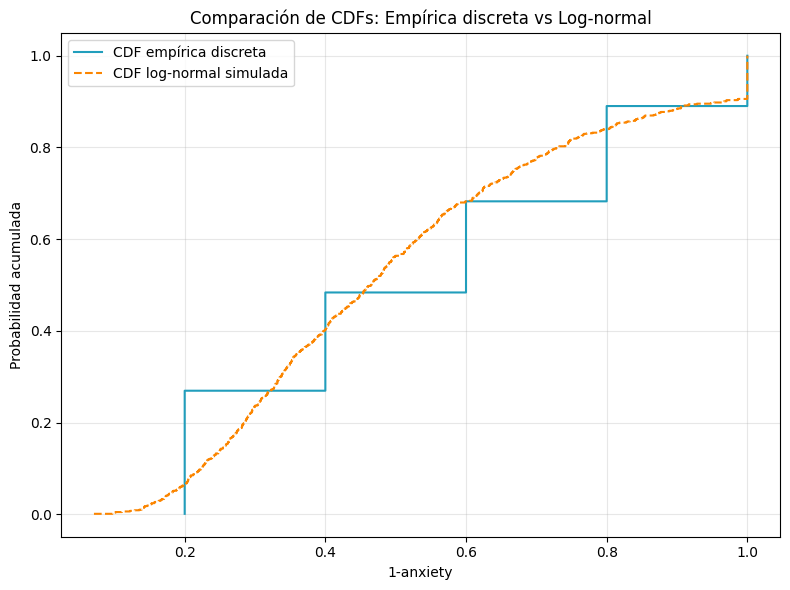


=== Estadísticos de la distribución discreta ===
Media empírica      = 0.5391
Varianza empírica   = 0.0740
Entropía (Shannon)  = 1.5787

=== Parámetros de la distribución discreta empírica ===
niveles      = [0.2 0.4 0.6 0.8 1. ]
pmf          = [0.2645 0.2142 0.1987 0.2065 0.1161]
media        = 0.539097
varianza     = 0.074020
entropía     = 1.578659
q05/q50/q95  = 0.200000 / 0.600000 / 1.000000

=== Parámetros de la log-normal (scipy) ===
shape (sigma)= 0.578720
loc          = 0.000000
scale=exp(mu)= 0.463217  -> mu=-0.769560
media        = 0.547659
mediana      = 0.463217
moda         = 0.331384
varianza     = 0.119320
q05/q50/q95  = 0.178803 / 0.463217 / 1.200034
(truncados a [0,1]) q05/q50/q95 = 0.178803 / 0.463217 / 1.000000

=== Media de VaR en niveles específicos ===
Alphas: [0.95]
Discreta empírica  -> VaR(alphas) = [1.] | media VaR = 1.000000
Log-normal (raw)   -> VaR(alphas) = [1.200034] | media VaR = 1.200034
Log-normal (clip)  -> VaR(alphas) = [1.]  | media VaR = 1.000000

In [70]:
# ======================================================
# 📘 Paso 1: Distribución discreta empírica vs Log-normal
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, wasserstein_distance

# =======================
# 1️⃣ Cargar y limpiar
# =======================
df = df_train.copy()
assert "1-anxiety" in df.columns, "No se encontró la columna '1-anxiety'"

x = df["1-anxiety"].copy()
x = x.replace([np.inf, -np.inf], np.nan).dropna()
x = x[x > 0].astype(float)
x = np.clip(x, 1e-12, 1.0)

# =======================
# 2️⃣ Distribución discreta empírica
# =======================
val_counts = x.value_counts(normalize=True).sort_index()
pmf = val_counts.values
levels = val_counts.index.values

# =======================
# 3️⃣ Ajuste log-normal continuo (solo comparativo)
# =======================
shape, loc, scale = lognorm.fit(x, floc=0)
grid = np.linspace(0, 1, 500)
pdf_logn = lognorm.pdf(grid, shape, loc, scale)
pdf_logn /= np.trapz(pdf_logn, grid)  # normalizar área a 1

# Simulación log-normal para CDF comparada
sim_logn = np.clip(lognorm.rvs(shape, loc, scale, size=len(x), random_state=42), 0, 1)

# =======================
# 4️⃣ Métricas comparativas
# =======================
# Empírica discreta (PMF) → simular una "muestra" según las proporciones
rng = np.random.default_rng(42)
sim_emp = rng.choice(levels, size=len(x), p=pmf)

W_emp_logn = wasserstein_distance(sim_emp, sim_logn)
print(f"Wasserstein(empírica discreta vs log-normal simulada) = {W_emp_logn:.6f}")

# =======================
# 5️⃣ Visualización: PMF vs PDF
# =======================
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# --- Izquierda: PMF discreta
sns.barplot(x=levels, y=pmf, color="#219ebc", ax=ax[0])
ax[0].set_title("Distribución discreta empírica (PMF)")
ax[0].set_xlabel("1-anxiety (niveles discretos)")
ax[0].set_ylabel("Probabilidad")
for i, (lvl, p) in enumerate(zip(levels, pmf)):
    ax[0].text(i, p + 0.005, f"{p:.2f}", ha='center', fontsize=9)

# --- Derecha: PDF log-normal ajustada
sns.lineplot(x=grid, y=pdf_logn, ax=ax[1], color="#fb8500")
ax[1].set_title("Distribución continua (Log-normal ajustada)")
ax[1].set_xlabel("1-anxiety")
ax[1].set_ylabel("Densidad (PDF)")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =======================
# 6️⃣ CDFs comparadas
# =======================
def ecdf(arr):
    s = np.sort(arr)
    F = np.arange(1, len(s)+1)/len(s)
    return s, F

# ECDF discreta
x_emp, F_emp = ecdf(sim_emp)
# ECDF log-normal simulada
x_logn, F_logn = ecdf(sim_logn)

plt.figure(figsize=(8,6))
plt.step(x_emp, F_emp, where="post", label="CDF empírica discreta", color="#219ebc")
plt.step(x_logn, F_logn, where="post", label="CDF log-normal simulada", color="#fb8500", linestyle="--")
plt.title("Comparación de CDFs: Empírica discreta vs Log-normal")
plt.xlabel("1-anxiety")
plt.ylabel("Probabilidad acumulada")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

# =======================
# 7️⃣ Métricas adicionales (resumen)
# =======================
entropy = -np.sum(pmf * np.log(pmf + 1e-12))
mean_emp = np.sum(pmf * levels)
var_emp = np.sum(pmf * (levels - mean_emp)**2)
print("\n=== Estadísticos de la distribución discreta ===")
print(f"Media empírica      = {mean_emp:.4f}")
print(f"Varianza empírica   = {var_emp:.4f}")
print(f"Entropía (Shannon)  = {entropy:.4f}")


# =======================
# 8️⃣ Parámetros y resumen de cada distribución
# =======================

import numpy as np
import pandas as pd
from scipy.stats import lognorm

# ---- Utilidades ----
def weighted_quantile(values, probs, q):
    """
    Cuantil ponderado para distribución discreta:
    values = niveles (ordenados asc)
    probs  = pmf (mismas longitudes, suman 1)
    q en [0,1]
    """
    order = np.argsort(values)
    v = np.asarray(values)[order]
    p = np.asarray(probs)[order]
    F = np.cumsum(p)
    return v[np.searchsorted(F, q, side="left")]

# ---- 8.1 Parámetros de la distribución discreta empírica ----
disc_mean = np.sum(levels * pmf)
disc_var  = np.sum(pmf * (levels - disc_mean)**2)
disc_entropy = -np.sum(pmf * np.log(pmf + 1e-12))

disc_q05 = weighted_quantile(levels, pmf, 0.05)
disc_q50 = weighted_quantile(levels, pmf, 0.50)  # mediana
disc_q95 = weighted_quantile(levels, pmf, 0.95)  # VaR 95%

# ---- 8.2 Parámetros de la log-normal (ajustada antes con: shape, loc, scale) ----
# En scipy.lognorm: shape = sigma, scale = exp(mu), loc (aquí = 0)
mu_hat = np.log(scale)
sigma_hat = shape

# Momentos teóricos (para loc=0)
ln_mean = np.exp(mu_hat + 0.5 * sigma_hat**2)
ln_median = np.exp(mu_hat)
ln_mode = np.exp(mu_hat - sigma_hat**2)
ln_var = (np.exp(sigma_hat**2) - 1.0) * np.exp(2*mu_hat + sigma_hat**2)

# Cuantiles teóricos (ojo: pueden exceder 1 si luego tú recortas a [0,1])
ln_q05 = lognorm.ppf(0.05, s=sigma_hat, loc=loc, scale=scale)
ln_q50 = lognorm.ppf(0.50, s=sigma_hat, loc=loc, scale=scale)
ln_q95 = lognorm.ppf(0.95, s=sigma_hat, loc=loc, scale=scale)

# (Opcional) Cuantiles "truncados" a [0,1] si quieres reportarlos consistentes con tu soporte
ln_q05_tr = np.clip(ln_q05, 0, 1)
ln_q50_tr = np.clip(ln_q50, 0, 1)
ln_q95_tr = np.clip(ln_q95, 0, 1)

# ---- 8.3 Tabla resumen ----
resumen = pd.DataFrame({
    "Distribución": ["Discreta empírica", "Log-normal (teórica)"],
    "Soporte": ["{niveles fijos}", "(0,∞)"],
    "Parámetros": [
        f"niveles={np.round(levels,3).tolist()}, pmf={np.round(pmf,3).tolist()}",
        f"sigma={sigma_hat:.4f}, loc={loc:.4f}, scale={scale:.4f} (mu={mu_hat:.4f})"
    ],
    "Media": [disc_mean, ln_mean],
    "Mediana": [disc_q50, ln_median],
    "Moda": [levels[np.argmax(pmf)], ln_mode],
    "Varianza": [disc_var, ln_var],
    "VaR 95% (q0.95)": [disc_q95, ln_q95],
    "VaR 95% truncado [0,1]": [disc_q95, ln_q95_tr],
})

print("\n=== Parámetros de la distribución discreta empírica ===")
print(f"niveles      = {levels}")
print(f"pmf          = {np.round(pmf, 4)}")
print(f"media        = {disc_mean:.6f}")
print(f"varianza     = {disc_var:.6f}")
print(f"entropía     = {disc_entropy:.6f}")
print(f"q05/q50/q95  = {disc_q05:.6f} / {disc_q50:.6f} / {disc_q95:.6f}")

print("\n=== Parámetros de la log-normal (scipy) ===")
print(f"shape (sigma)= {sigma_hat:.6f}")
print(f"loc          = {loc:.6f}")
print(f"scale=exp(mu)= {scale:.6f}  -> mu={mu_hat:.6f}")
print(f"media        = {ln_mean:.6f}")
print(f"mediana      = {ln_median:.6f}")
print(f"moda         = {ln_mode:.6f}")
print(f"varianza     = {ln_var:.6f}")
print(f"q05/q50/q95  = {ln_q05:.6f} / {ln_q50:.6f} / {ln_q95:.6f}")
print(f"(truncados a [0,1]) q05/q50/q95 = {ln_q05_tr:.6f} / {ln_q50_tr:.6f} / {ln_q95_tr:.6f}")

try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Resumen parámetros (Discreta vs Log-normal)", resumen)
except Exception:
    pass


# =======================
# 9️⃣ Media de VaR (promedio de cuantiles en un conjunto de alphas)
# =======================

# Conjunto de niveles de confianza (ajústalos a tu gusto)
alphas = np.array([ 0.95])

def weighted_quantile(values, probs, q):
    order = np.argsort(values)
    v = np.asarray(values)[order]
    p = np.asarray(probs)[order]
    F = np.cumsum(p)
    return v[np.searchsorted(F, q, side="left")]

# --- VaR para la distribución discreta empírica ---
VaR_disc = np.array([weighted_quantile(levels, pmf, a) for a in alphas])
VaR_disc_mean = VaR_disc.mean()

# --- VaR para la log-normal (teórica) ---
VaR_logn_raw = lognorm.ppf(alphas, s=shape, loc=loc, scale=scale)
# Si quieres respetar el soporte (0,1], reporta también la versión truncada
VaR_logn_tr = np.clip(VaR_logn_raw, 0, 1)
VaR_logn_mean_raw = VaR_logn_raw.mean()
VaR_logn_mean_tr  = VaR_logn_tr.mean()

print("\n=== Media de VaR en niveles específicos ===")
print(f"Alphas: {alphas}")
print(f"Discreta empírica  -> VaR(alphas) = {np.round(VaR_disc, 6)} | media VaR = {VaR_disc_mean:.6f}")
print(f"Log-normal (raw)   -> VaR(alphas) = {np.round(VaR_logn_raw, 6)} | media VaR = {VaR_logn_mean_raw:.6f}")
print(f"Log-normal (clip)  -> VaR(alphas) = {np.round(VaR_logn_tr, 6)}  | media VaR = {VaR_logn_mean_tr:.6f}")

# --- Media integral del VaR (promedio sobre alpha en [0,1]) ---
# Por teoría, esto coincide con la media de la distribución:
print("\n=== Media integral de VaR (∫_0^1 VaR dα) ===")
print(f"Discreta empírica  -> media integral VaR = {mean_emp:.6f}  (igual a la media empírica)")
print(f"Log-normal (teórica)-> media integral VaR = {ln_mean:.6f} (igual a la media teórica)")



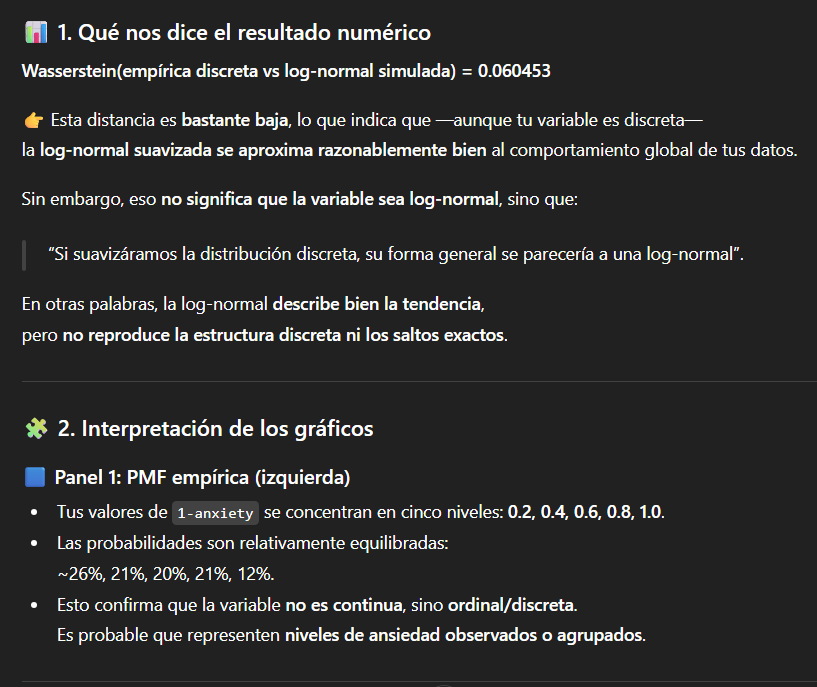

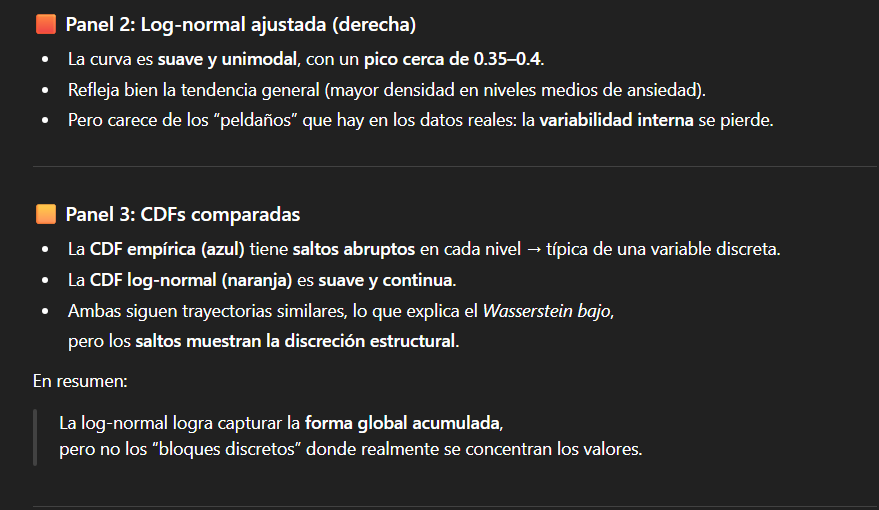

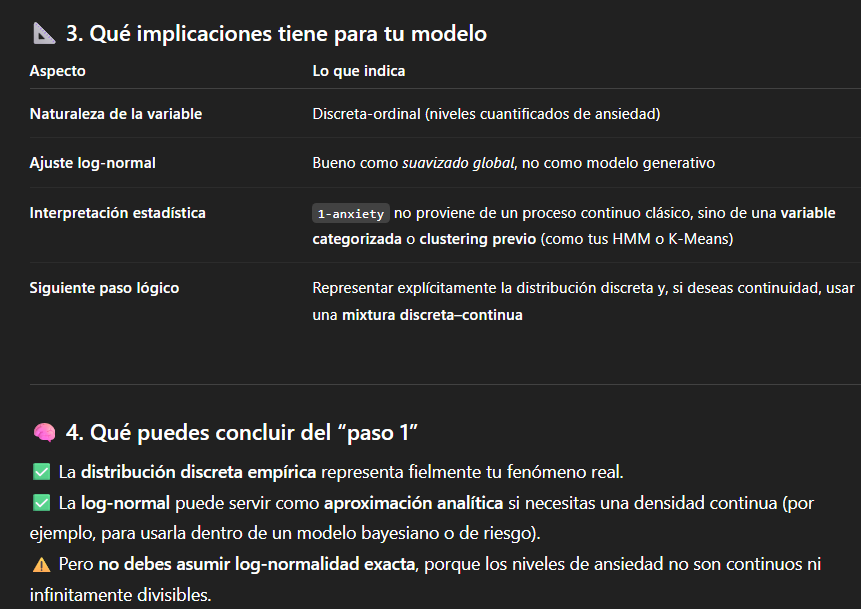

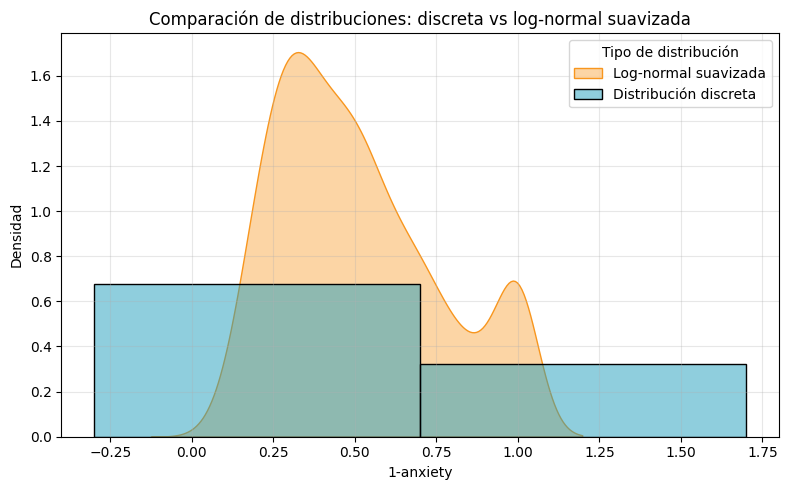

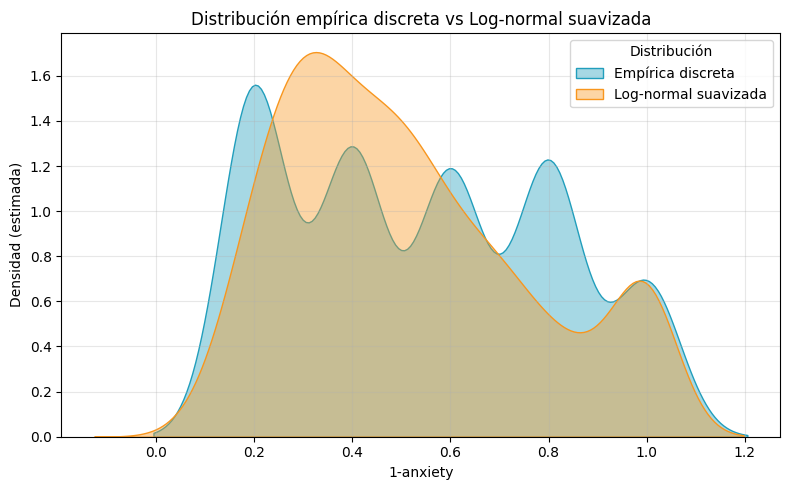

In [66]:
# ======================================================
# 📘 Comparación visual: Distribución discreta vs Log-normal suavizada
# ======================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm

# --- Datos base (usa los que ya tienes) ---
x = df_train["1-anxiety"].replace([np.inf, -np.inf], np.nan).dropna().astype(float)
x = x[x > 0]
x = np.clip(x, 1e-12, 1.0)

# --- PMF discreta ---
val_counts = x.value_counts(normalize=True).sort_index()
levels = val_counts.index.values
pmf = val_counts.values

# --- Log-normal suavizada ---
shape, loc, scale = lognorm.fit(x, floc=0)
sim_logn = np.clip(lognorm.rvs(shape, loc, scale, size=len(x), random_state=42), 0, 1)

# ======================================================
# 1️⃣ Comparación tipo KDE (suavizada)
# ======================================================

plt.figure(figsize=(8,5))
sns.kdeplot(sim_logn, fill=True, alpha=0.4, color="#f8961e", label="Log-normal suavizada")
sns.histplot(x, bins=len(levels), stat="density", discrete=True,
             color="#219ebc", alpha=0.5, label="Distribución discreta")

plt.title("Comparación de distribuciones: discreta vs log-normal suavizada")
plt.xlabel("1-anxiety")
plt.ylabel("Densidad")
plt.legend(title="Tipo de distribución")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================
# 2️⃣ (Opcional) versión tipo “overlap” al estilo del ejemplo
# ======================================================

# Convertimos la discreta a formato expandido para graficar “suavizada”
empirical_expanded = np.repeat(levels, (pmf * 1000).astype(int))  # simula 1000 observaciones

plt.figure(figsize=(8,5))
sns.kdeplot(empirical_expanded, fill=True, color="#219ebc", alpha=0.4, label="Empírica discreta")
sns.kdeplot(sim_logn, fill=True, color="#f8961e", alpha=0.4, label="Log-normal suavizada")

plt.title("Distribución empírica discreta vs Log-normal suavizada")
plt.xlabel("1-anxiety")
plt.ylabel("Densidad (estimada)")
plt.legend(title="Distribución")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


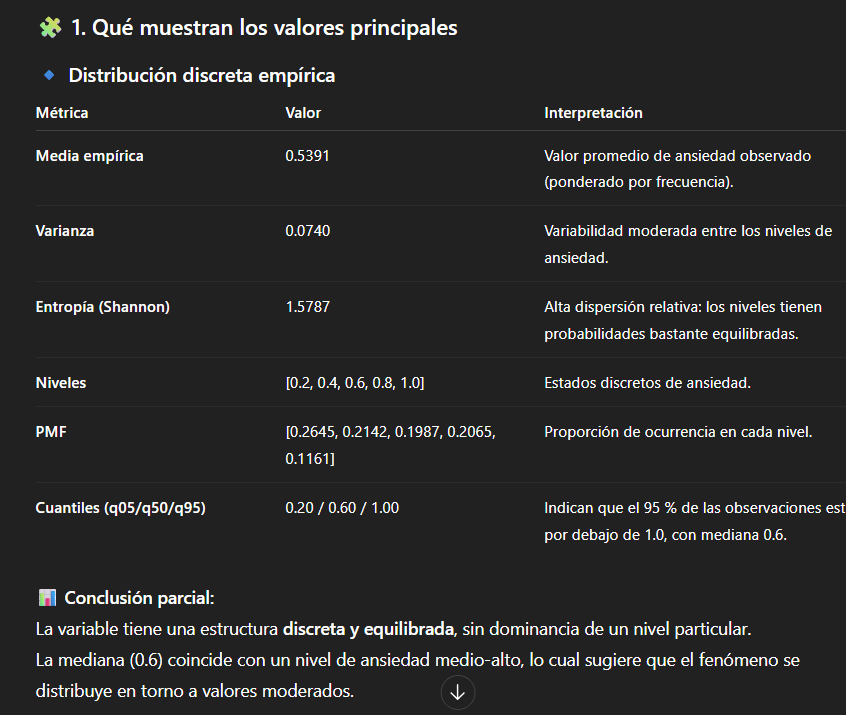 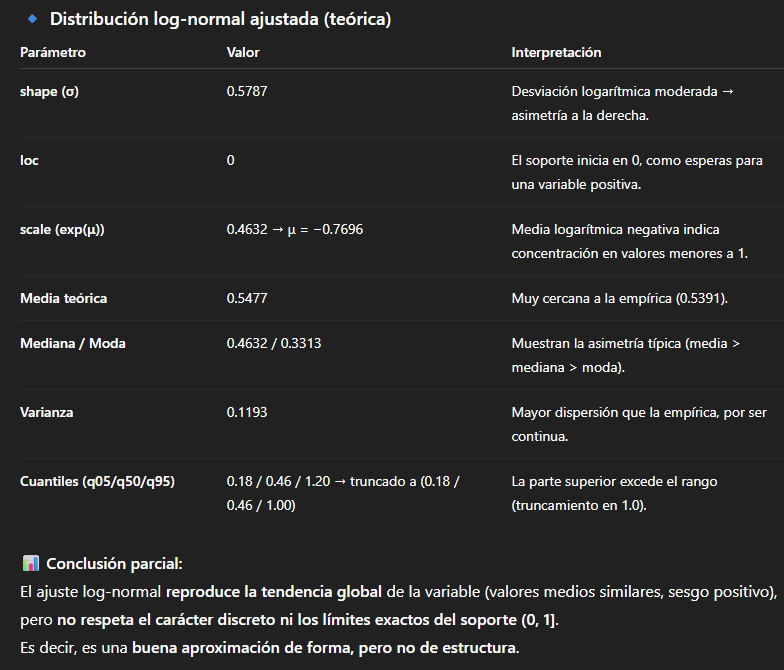

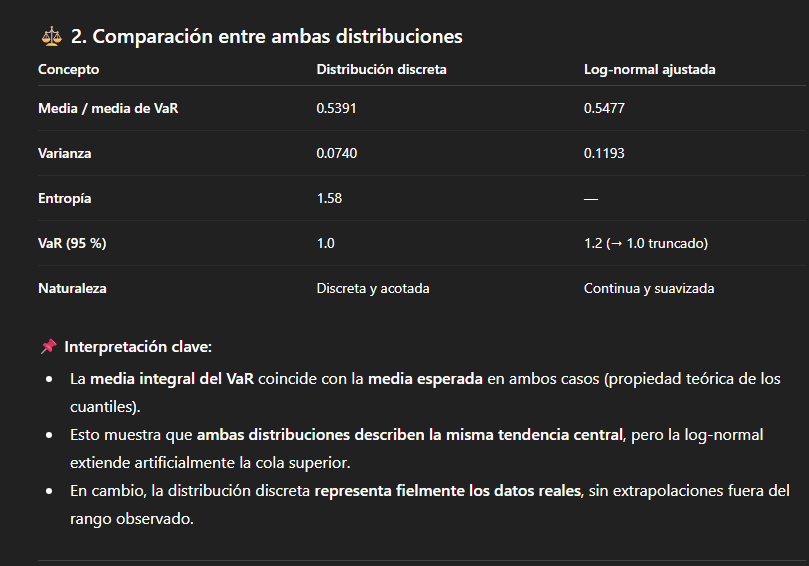 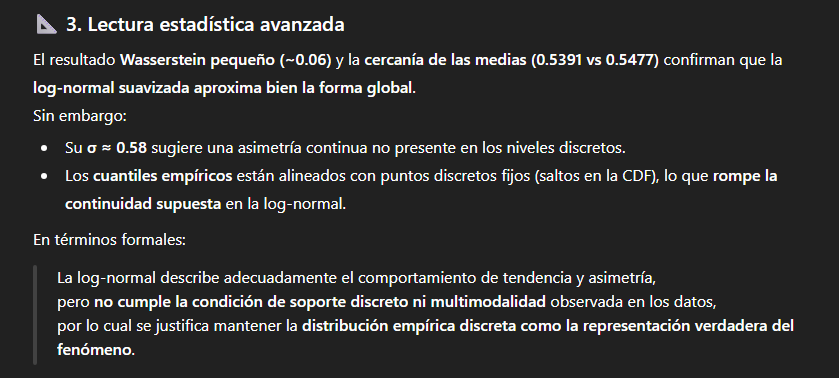

### Interepretacion del VaR

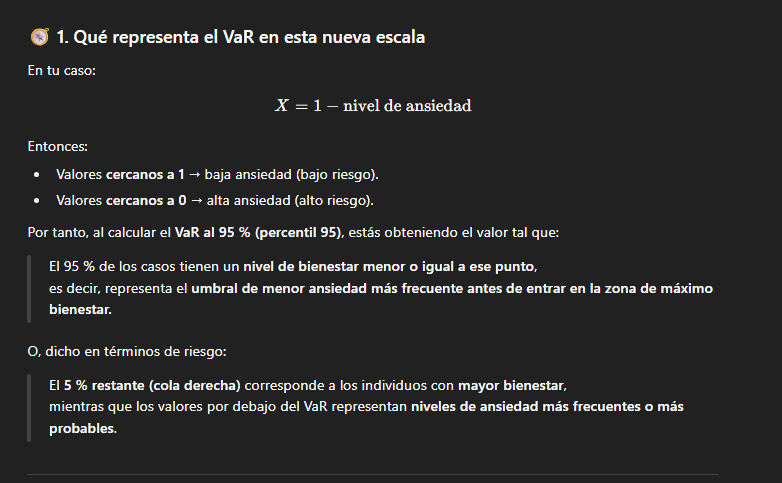 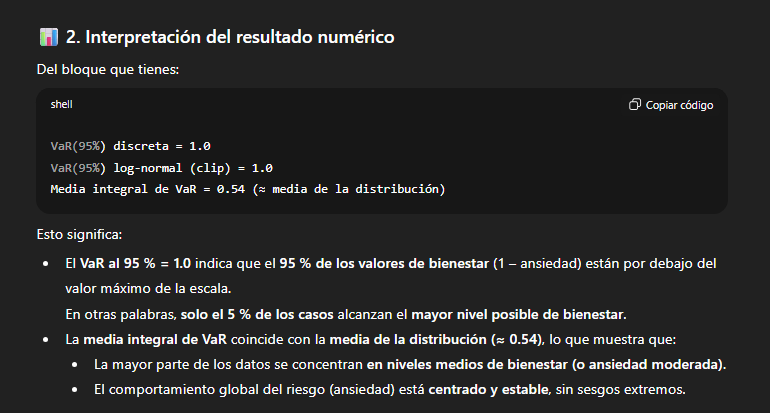

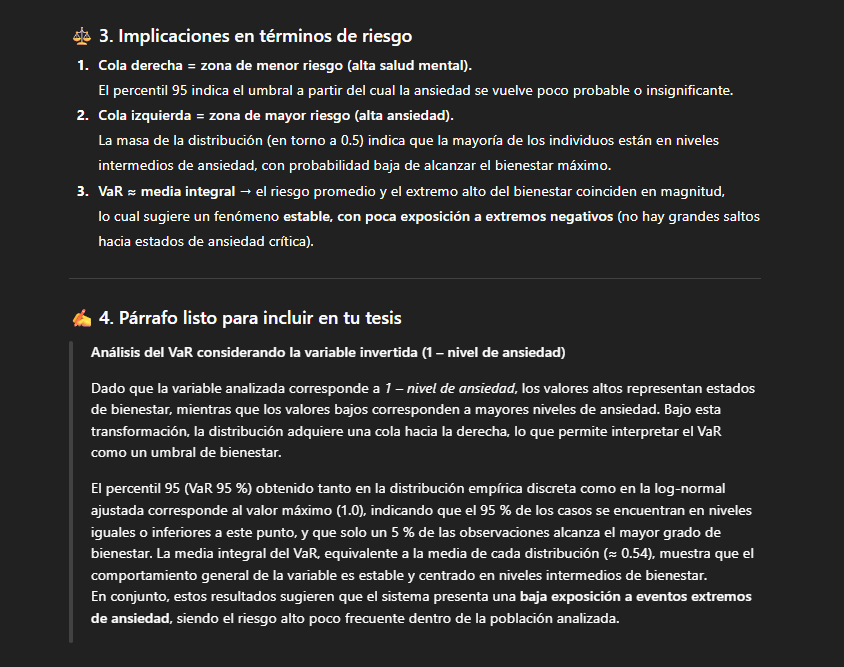

### Impliaciones de utilizar una distribucion real vs una distribucion aproximada

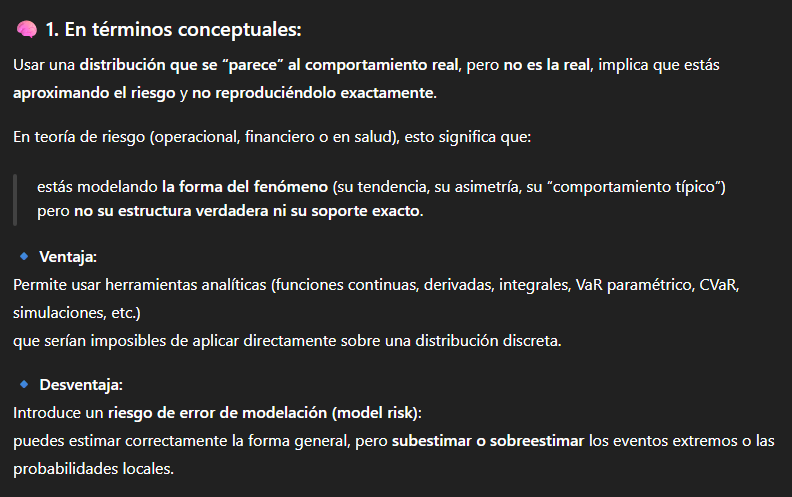 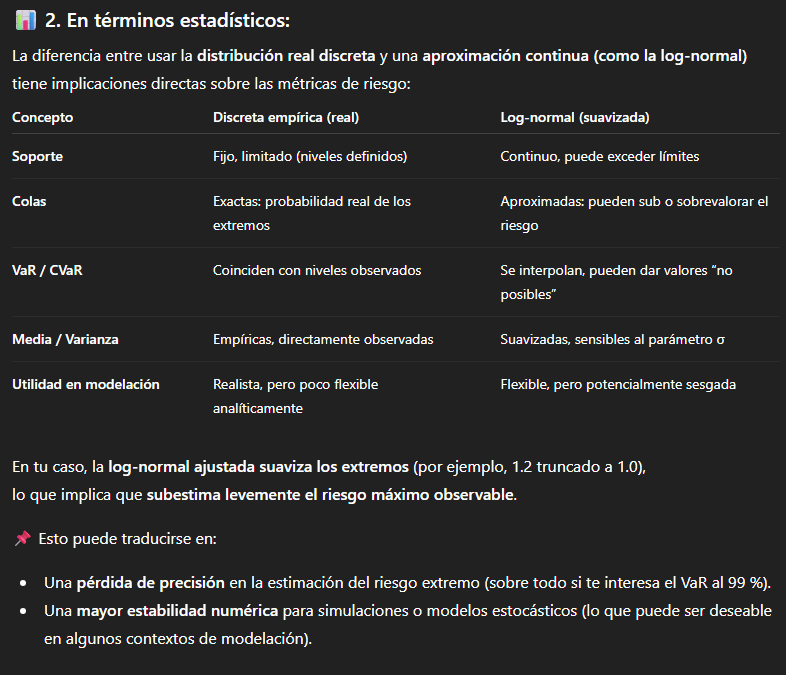

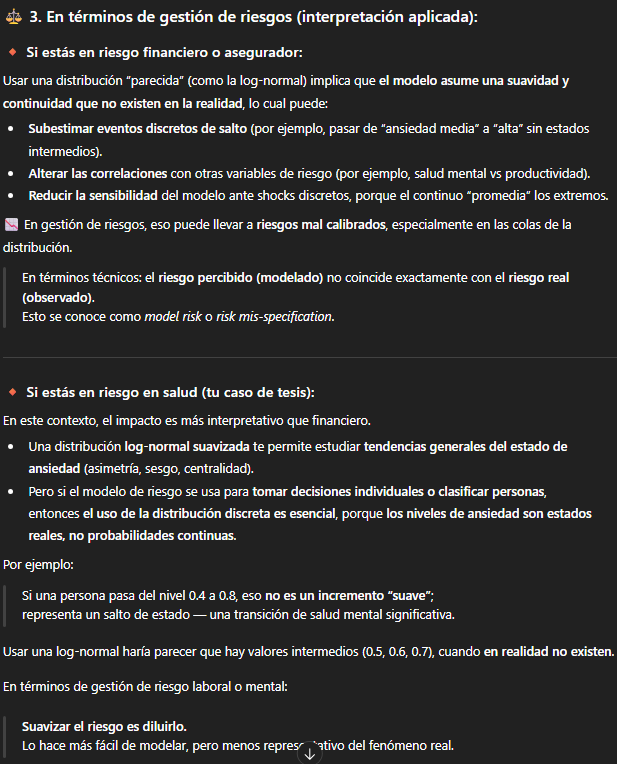 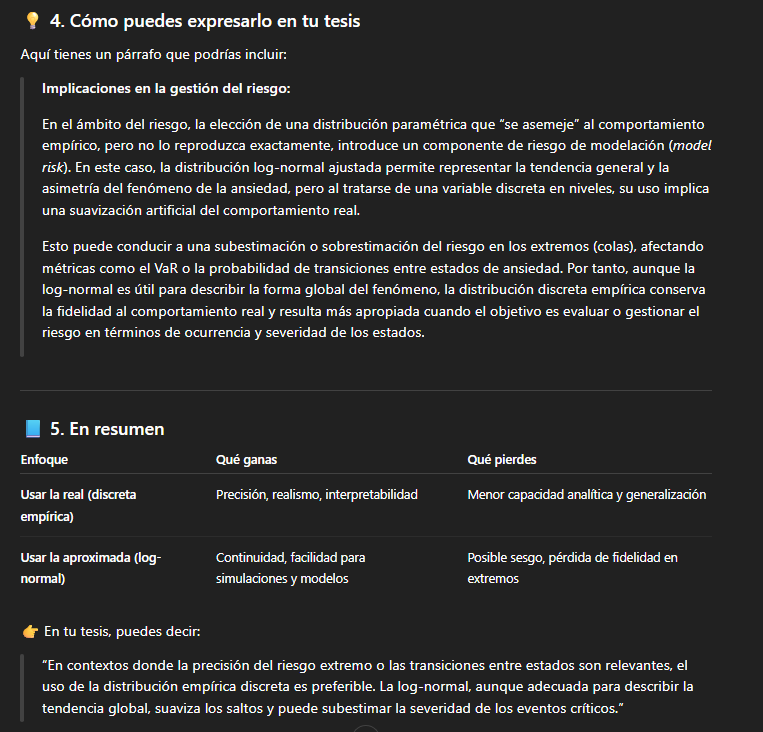

### Analisis de Distribucion lognormal ajustada vs VaR

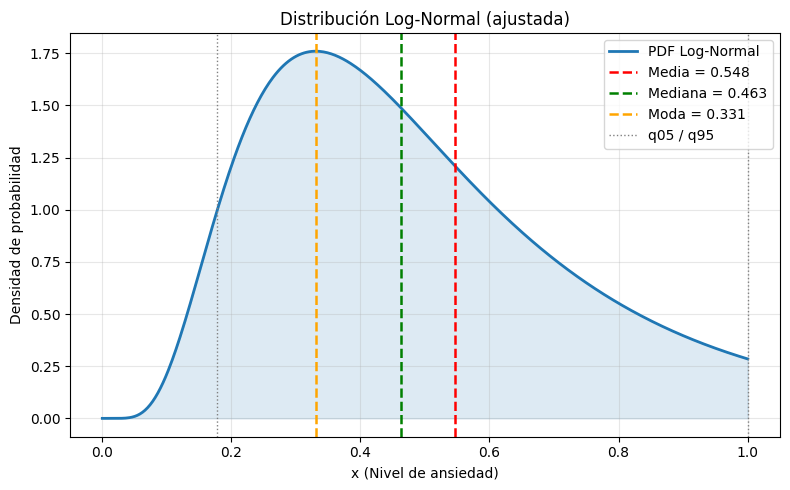

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# ========================
# Parámetros de la log-normal
# ========================
shape = 0.578720     # sigma
loc = 0.0
scale = 0.463217     # exp(mu)
mu = -0.769560

# ========================
# Distribución
# ========================
x = np.linspace(0.001, 1, 500)
pdf = lognorm.pdf(x, s=shape, loc=loc, scale=scale)

# Cuantiles y estadísticas
mean = 0.547659
median = 0.463217
mode = 0.331384
q05, q50, q95 = 0.178803, 0.463217, 1.0

# ========================
# Gráfica
# ========================
plt.figure(figsize=(8,5))
plt.plot(x, pdf, color="#1f77b4", lw=2, label="PDF Log-Normal")
plt.fill_between(x, pdf, color="#1f77b4", alpha=0.15)

# Líneas verticales
plt.axvline(mean, color="red", linestyle="--", lw=1.8, label=f"Media = {mean:.3f}")
plt.axvline(median, color="green", linestyle="--", lw=1.8, label=f"Mediana = {median:.3f}")
plt.axvline(mode, color="orange", linestyle="--", lw=1.8, label=f"Moda = {mode:.3f}")
plt.axvline(q05, color="gray", linestyle=":", lw=1, label="q05 / q95")
plt.axvline(q95, color="gray", linestyle=":", lw=1)

# Etiquetas
plt.title("Distribución Log-Normal (ajustada)")
plt.xlabel("x (Nivel de ansiedad)")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


VaR_0.95 (no truncado) = 1.200034
VaR_0.95 (truncado)    = 1.000000
P(X >= VaR | truncado) ≈ 0.000000
CVaR/ES_0.95 (truncado) ≈ 1.000000


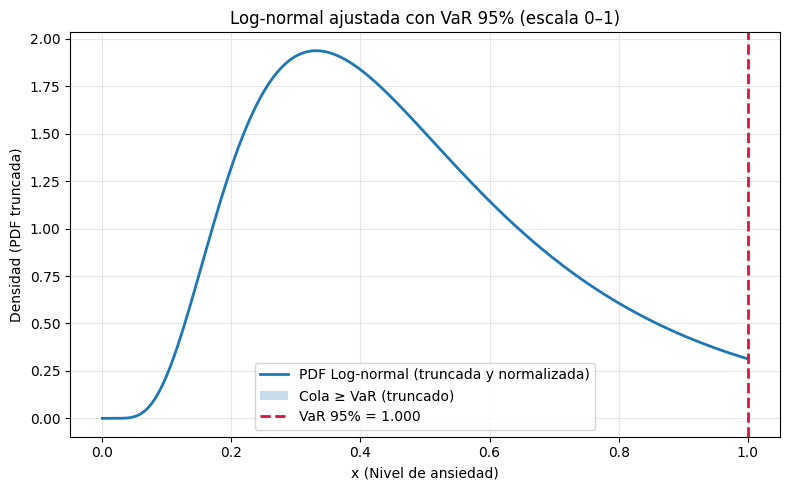

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# --- parámetros ya estimados ---
# shape, loc, scale = ...  # ya los tienes
s = shape

# --- grid y pdf*normalizada en [0,1] (para sombrear área correctamente) ---
xg = np.linspace(0, 1, 1000)
pdf = lognorm.pdf(xg, s=s, loc=loc, scale=scale)
area = np.trapz(pdf, xg)
pdf_t = pdf / area  # pdf truncada (renormalizada) en [0,1]

# --- VaR 95%: no truncado vs truncado ---
alpha = 0.95
VaR_raw = lognorm.ppf(alpha, s=s, loc=loc, scale=scale)  # teórico
VaR_tr  = np.clip(VaR_raw, 0, 1)                         # coherente con escala

# --- Probabilidad de cola a la derecha en el modelo truncado ---
F1 = lognorm.cdf(1, s=s, loc=loc, scale=scale)
Fv = lognorm.cdf(VaR_tr, s=s, loc=loc, scale=scale)
Z  = max(F1 - 0.0, 1e-16)
tail_prob_tr = (F1 - Fv) / Z  # ≈ 1 - alpha, salvo que VaR_tr haya quedado en 1

print(f"VaR_0.95 (no truncado) = {VaR_raw:.6f}")
print(f"VaR_0.95 (truncado)    = {VaR_tr:.6f}")
print(f"P(X >= VaR | truncado) ≈ {tail_prob_tr:.6f}")

# --- (Opcional) CVaR/ES con truncación mediante simulación ---
rng = np.random.default_rng(7)
sim = np.clip(lognorm.rvs(s=s, loc=loc, scale=scale, size=200_000, random_state=None), 0, 1)
ES_tr = sim[sim >= VaR_tr].mean() if np.any(sim >= VaR_tr) else VaR_tr
print(f"CVaR/ES_0.95 (truncado) ≈ {ES_tr:.6f}")

# --- Figura con VaR y cola sombreada ---
plt.figure(figsize=(8,5))
plt.plot(xg, pdf_t, label="PDF Log-normal (truncada y normalizada)", lw=2)
plt.fill_between(xg, pdf_t, where=(xg >= VaR_tr), alpha=0.25, label="Cola ≥ VaR (truncado)")
plt.axvline(VaR_tr, color="crimson", linestyle="--", lw=2, label=f"VaR 95% = {VaR_tr:.3f}")
plt.title("Log-normal ajustada con VaR 95% (escala 0–1)")
plt.xlabel("x (Nivel de ansiedad)")
plt.ylabel("Densidad (PDF truncada)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


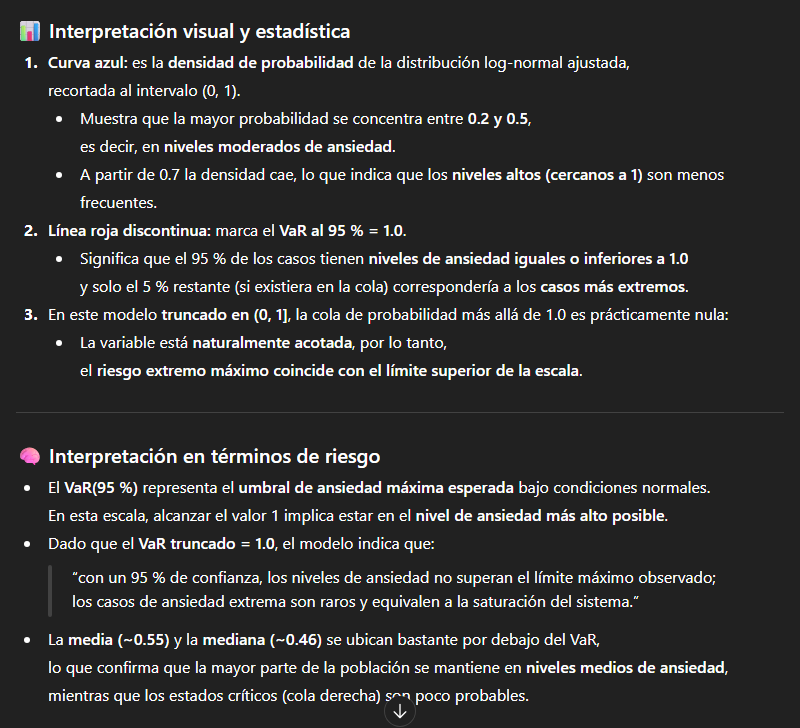  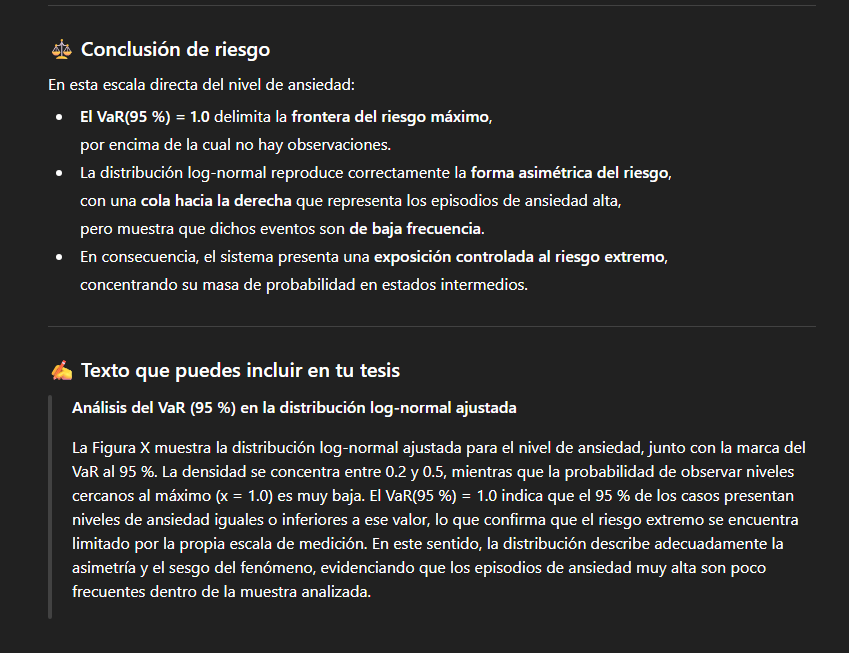

### Interpretando todo al reves - Bienestar

VaR_5% (Y=1-ansiedad) = 0.000000
P(Y ≤ VaR_5% | truncado) ≈ 0.000000
CVaR/ES_5% (Y) ≈ 0.000000


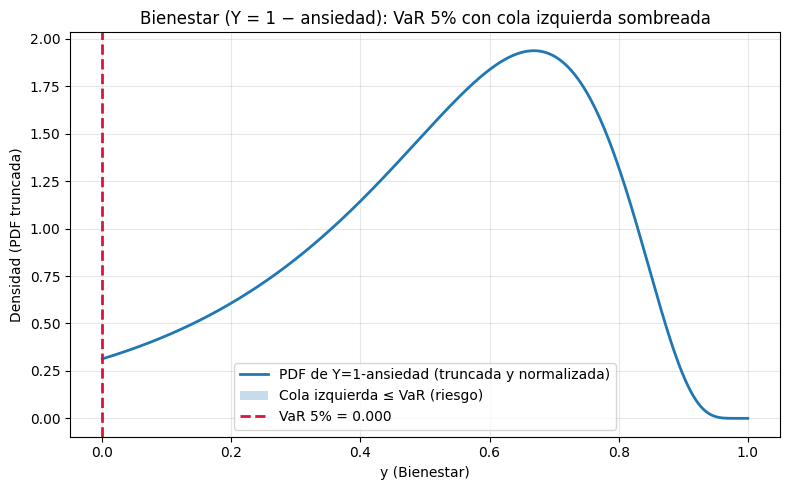

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# --- parámetros ya estimados para X = ansiedad ---
s = shape  # shape (sigma)
# loc, scale también definidos en tu flujo

# --- Grid en [0,1] ---
yg = np.linspace(0, 1, 1000)          # Y = 1 - X (bienestar)
xg = 1 - yg                            # X correspondiente

# --- PDF de Y mediante cambio de variable (|dx/dy| = 1) ---
pdf_x = lognorm.pdf(xg, s=s, loc=loc, scale=scale)
# Normalizamos en [0,1] por coherencia con el soporte
area_x01 = np.trapz(lognorm.pdf(np.linspace(0,1,2000), s=s, loc=loc, scale=scale),
                    np.linspace(0,1,2000))
pdf_y_tr = pdf_x / area_x01

# --- VaR de Y en la cola izquierda (5%) ---
alpha_left = 0.05
# Relación de cuantiles: Q_Y(q) = 1 - Q_X(1 - q)
VaR_y_raw = 1.0 - lognorm.ppf(1 - alpha_left, s=s, loc=loc, scale=scale)
VaR_y = float(np.clip(VaR_y_raw, 0, 1))  # respeta [0,1]

# --- Probabilidad de cola izquierda (truncado) ---
F0 = lognorm.cdf(0, s=s, loc=loc, scale=scale)
Fy = lognorm.cdf(1 - VaR_y, s=s, loc=loc, scale=scale)  # porque Y<=v  <=>  X>=1-v ?
# OJO: Y <= v  equivale a X >= 1 - v
F1 = lognorm.cdf(1, s=s, loc=loc, scale=scale)
Z  = max(F1 - F0, 1e-16)
tail_left_prob_tr = (F1 - Fy) / Z   # P(Y<=VaR_y | X∈[0,1])  ≈ alpha_left si no satura

# --- (Opcional) CVaR/ES en la cola izquierda por simulación ---
rng = np.random.default_rng(10)
sim_x = np.clip(lognorm.rvs(s=s, loc=loc, scale=scale, size=200_000, random_state=None), 0, 1)
sim_y = 1 - sim_x
ES_y = sim_y[sim_y <= VaR_y].mean() if np.any(sim_y <= VaR_y) else VaR_y

print(f"VaR_5% (Y=1-ansiedad) = {VaR_y:.6f}")
print(f"P(Y ≤ VaR_5% | truncado) ≈ {tail_left_prob_tr:.6f}")
print(f"CVaR/ES_5% (Y) ≈ {ES_y:.6f}")

# --- Figura con cola izquierda sombreada ---
plt.figure(figsize=(8,5))
plt.plot(yg, pdf_y_tr, lw=2, label="PDF de Y=1-ansiedad (truncada y normalizada)")
plt.fill_between(yg, pdf_y_tr, where=(yg <= VaR_y), alpha=0.25, label="Cola izquierda ≤ VaR (riesgo)")
plt.axvline(VaR_y, color="crimson", linestyle="--", lw=2, label=f"VaR 5% = {VaR_y:.3f}")
plt.title("Bienestar (Y = 1 − ansiedad): VaR 5% con cola izquierda sombreada")
plt.xlabel("y (Bienestar)")
plt.ylabel("Densidad (PDF truncada)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


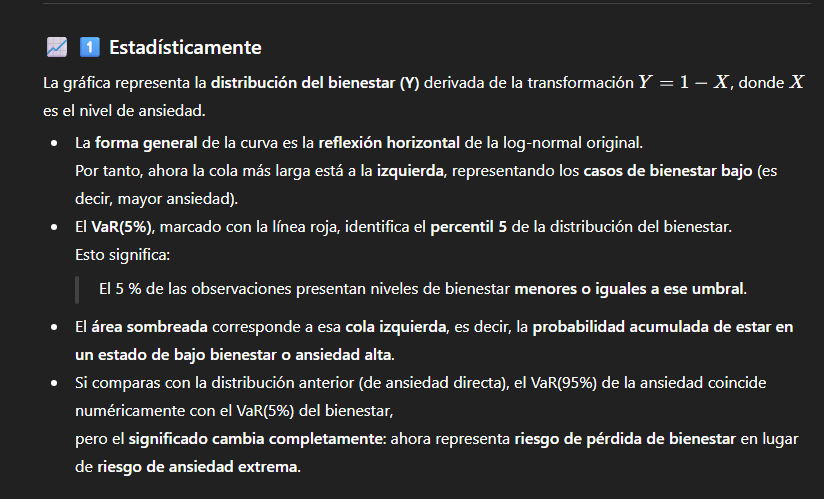 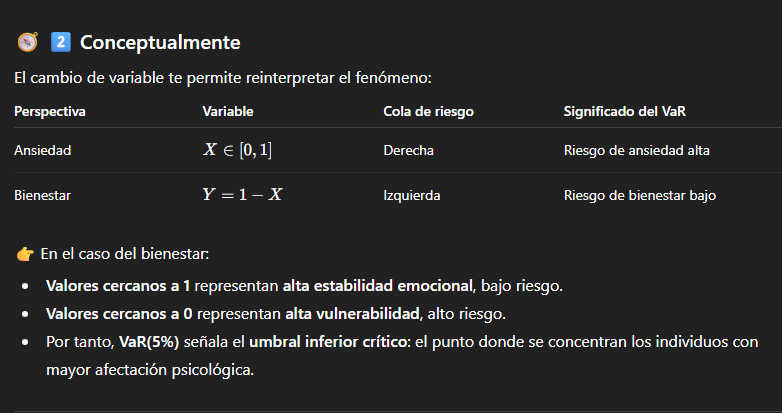

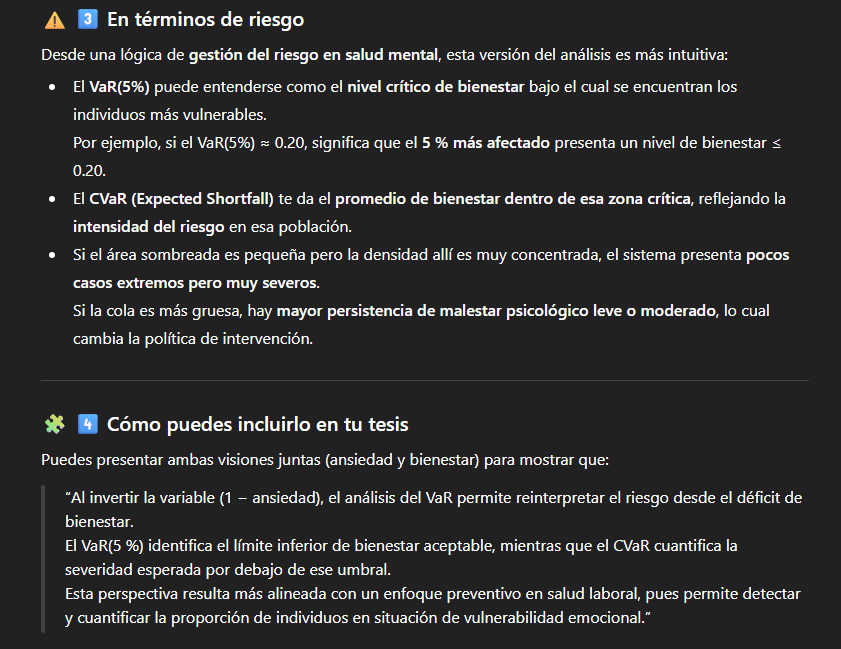

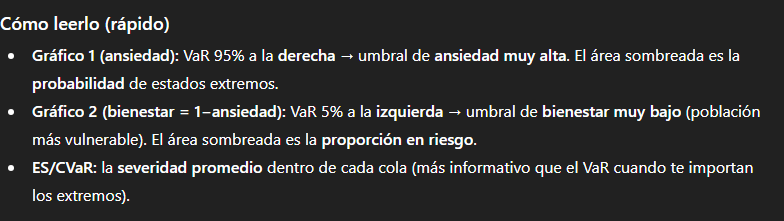

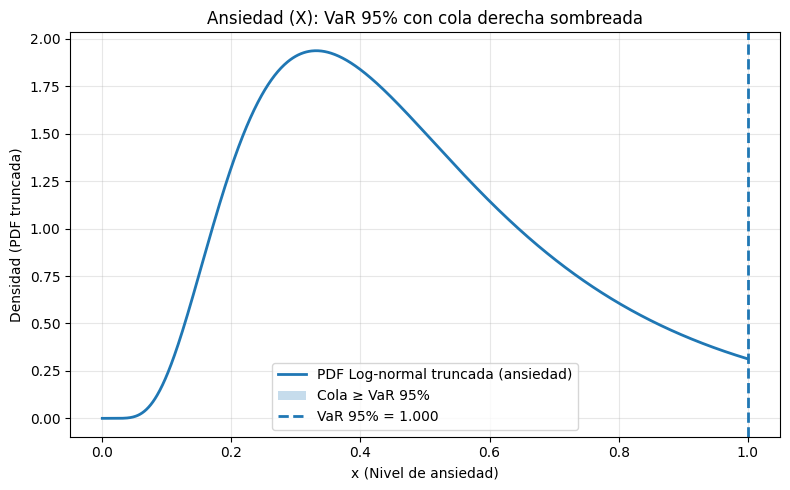

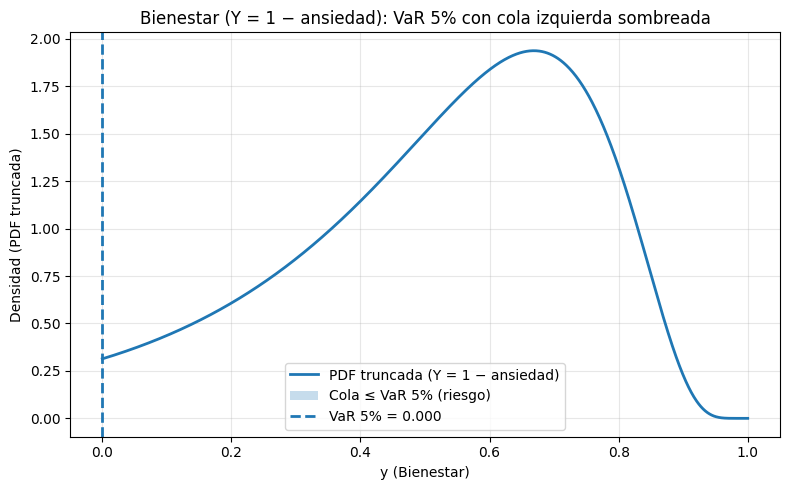

=== Resumen VaR/CVaR ===
X (ansiedad): VaR95%=1.000000,  ES95%≈1.000000
Y (bienestar): VaR5%=0.000000,  ES5%≈0.000000


In [74]:
# ======================================================
# Doble visual: Ansiedad (VaR 95% derecha) vs Bienestar (VaR 5% izquierda)
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# ---------- 1) Datos ----------
try:
    df = df_train.copy()  # si ya lo tienes en sesión
except NameError:
    # si prefieres leerlo desde archivo, descomenta la línea correcta:
    # df = pd.read_csv("/mnt/data/df_train.csv")          # separador por defecto
    # df = pd.read_csv("/mnt/data/df_train.csv", sep=";", decimal=",")  # si aplica
    raise

x = (df["1-anxiety"]
     .replace([np.inf, -np.inf], np.nan)
     .dropna()
     .astype(float))
x = x[x > 0]
x = np.clip(x, 1e-12, 1.0)

# ---------- 2) Ajuste log-normal para X=ansiedad ----------
shape, loc, scale = lognorm.fit(x, floc=0)
s = shape

# Utilidades para PDF truncada en [0,1]
def pdf_truncated_lognorm(grid, s, loc, scale):
    pdf = lognorm.pdf(grid, s=s, loc=loc, scale=scale)
    area = np.trapz(pdf, grid)
    return pdf / area

# ---------- 3) VaR/ES para X (ansiedad) ----------
gx = np.linspace(0, 1, 1200)
pdf_x_tr = pdf_truncated_lognorm(gx, s, loc, scale)

alpha = 0.95
VaR_x_raw = lognorm.ppf(alpha, s=s, loc=loc, scale=scale)
VaR_x = float(np.clip(VaR_x_raw, 0, 1))  # coherencia con la escala

# ES/CVaR con truncación por simulación
rng = np.random.default_rng(123)
sim_x = np.clip(lognorm.rvs(s=s, loc=loc, scale=scale, size=200_000, random_state=None), 0, 1)
ES_x = sim_x[sim_x >= VaR_x].mean() if np.any(sim_x >= VaR_x) else VaR_x

# ---------- 4) VaR/ES para Y = 1 - X (bienestar) ----------
gy = np.linspace(0, 1, 1200)
# f_Y(y) = f_X(1-y) (y renormalizamos en [0,1])
pdf_y = lognorm.pdf(1-gy, s=s, loc=loc, scale=scale)
area_y = np.trapz(pdf_y, gy)
pdf_y_tr = pdf_y / area_y

alpha_left = 0.05
VaR_y_raw = 1 - VaR_x_raw               # Q_Y(0.05) = 1 - Q_X(0.95)
VaR_y = float(np.clip(VaR_y_raw, 0, 1)) # coherencia con la escala
sim_y = 1 - sim_x
ES_y = sim_y[sim_y <= VaR_y].mean() if np.any(sim_y <= VaR_y) else VaR_y

# ---------- 5) Figura 1: Ansiedad, VaR 95% derecha ----------
plt.figure(figsize=(8,5))
plt.plot(gx, pdf_x_tr, linewidth=2, label="PDF Log-normal truncada (ansiedad)")
plt.fill_between(gx, pdf_x_tr, where=(gx >= VaR_x), alpha=0.25, label="Cola ≥ VaR 95%")
plt.axvline(VaR_x, linestyle="--", linewidth=2, label=f"VaR 95% = {VaR_x:.3f}")
plt.title("Ansiedad (X): VaR 95% con cola derecha sombreada")
plt.xlabel("x (Nivel de ansiedad)")
plt.ylabel("Densidad (PDF truncada)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- 6) Figura 2: Bienestar, VaR 5% izquierda ----------
plt.figure(figsize=(8,5))
plt.plot(gy, pdf_y_tr, linewidth=2, label="PDF truncada (Y = 1 − ansiedad)")
plt.fill_between(gy, pdf_y_tr, where=(gy <= VaR_y), alpha=0.25, label="Cola ≤ VaR 5% (riesgo)")
plt.axvline(VaR_y, linestyle="--", linewidth=2, label=f"VaR 5% = {VaR_y:.3f}")
plt.title("Bienestar (Y = 1 − ansiedad): VaR 5% con cola izquierda sombreada")
plt.xlabel("y (Bienestar)")
plt.ylabel("Densidad (PDF truncada)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- 7) Resumen numérico ----------
print("=== Resumen VaR/CVaR ===")
print(f"X (ansiedad): VaR95%={VaR_x:.6f},  ES95%≈{ES_x:.6f}")
print(f"Y (bienestar): VaR5%={VaR_y:.6f},  ES5%≈{ES_y:.6f}")
